<a href="https://colab.research.google.com/github/gmcjcmg/Spoon-Knife/blob/main/DMV_Area_Group_2_Iteration_2_Code_Scraps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run the cell below once at the beginning of each session. The output can then be cleared. There is also a method to permanently install se-lib to eliminate this step.

In [ ]:
!pip install numpy matplotlib pandas ffmpeg-python

!pip install ipywidgets

!conda install ffmpeg

!pip install se-lib

from selib import *

import numpy as np
import matplotlib.pyplot as plt
# set plot attributes
import matplotlib as mpl

%matplotlib inline

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

/bin/bash: line 1: conda: command not found


# Project Version 1


In [ ]:
# Simulate Capabilities of Body Armor Systems

import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, radians
import pandas as pd
from matplotlib.animation import FuncAnimation

# Set random seed for reproducibility
np.random.seed(42)

# Initialize model parameters
start_time = 0
stop_time = 480  # minutes
dt = 1  # 1 minute time step
time_steps = np.arange(start_time, stop_time + dt, dt)

t = time_steps

# 1. Initialize Blue Forces position
x = np.random.uniform(0, 5000)  # meters
y = np.random.uniform(0, 5000)  # meters
positions = [(x, y)]  # Store path

# 2. Initialize stock
blue_forces_stock = 10 # unit size
stock_history = [blue_forces_stock]

# 3. Initialize direction
direction = np.random.uniform(0, 360)  # degrees
direction_history = [direction]

# Pandolf-Santee parameters
m = np.random.normal(76.6571, 11.06765) # Warfighter mass distribution (kg) (Economos, 2003, p. 5)
base_combat_load = 20.6497926 # Base Combat Load (kg) (Fish and Scharre, 2018, p. 13)
armor_load = 8.3043963255 # (kg)
L = base_combat_load + armor_load # Load carried on the body (kg)

# Terrain probabilities: Terrain factors from (Richmond et al., 2019, p. 49) and (Soule & Goldman, 1972, p. 708)

terrain_types = { #Fixed the error here by removing an extra ))
    'paved': {'range': (1, 10), 'eta': 1.0},
    'dirt_road': {'range': (11, 20), 'eta': 1.1},
    'light_brush': {'range': (21, 70), 'eta': 1.2},
    'heavy_brush': {'range': (71, 85), 'eta': 1.5},
    'loose_sand': {'range': (86, 100), 'eta': 2.1}
}

# Initialize histories
P_history = []
E_history = []
exhaustion_reserve_history = []
total_exhaustion_state = 0
exhaustion_state_history = [total_exhaustion_state]
terrain_history = []
v_history = []
G_history = []

# Simulation loop
for t in time_steps:
    # Stop conditions
    if blue_forces_stock <= 0:
        print(f"Stopped at t={t}: Blue Forces stock = 0")
        break
    if t >= stop_time:
        print(f"Stopped at t={t}: Reached maximum time")
        break
    if total_exhaustion_state >= (
        -0.0841 * (t/60)**4 + 2.9025*(t/60)**3 - 41.059*(t/60)**2 + 195.14*(t/60) + 294.05
    ):
        print(f"Stopped at t={t}: Exhaustion stop condition met")
        break

    # 7a. Update direction
    direction = np.random.uniform(direction - 5, direction + 5)
    direction = direction % 360  # Keep within [0, 360]

    # 7c. Generate speed factor
    v = np.random.uniform(0.388889, 0.944444)  # m/s

    # 7d. Calculate distance (meters)
    distance = v * dt * 60  # v * dt (in minutes) converted to seconds

    # 7e. Calculate new position
    x_new = x + distance * cos(radians(direction))
    y_new = y + distance * sin(radians(direction))

    # 7f, 7g. Boundary checks
    if x_new < 0 or x_new > 5000:
        direction = (direction + np.random.uniform(90, 180)) % 360
        x_new = x + distance * cos(radians(direction))
        y_new = y + distance * sin(radians(direction))
    if y_new < 0 or y_new > 5000:
        direction = (direction + np.random.uniform(90, 180)) % 360
        x_new = x + distance * cos(radians(direction))
        y_new = y + distance * sin(radians(direction))

    # Update position
    x, y = x_new, y_new
    positions.append((x, y))
    direction_history.append(direction)

    # 7j. Select terrain
    terrain_roll = np.random.randint(1, 101)
    terrain = None
    eta = None
    for terrain_name, props in terrain_types.items():
        low, high = props['range']
        if low <= terrain_roll <= high:
            terrain = terrain_name
            eta = props['eta']
            break

    # 7i. Pandolf-Santee parameters
    G = np.random.normal(0, 10) #Grade or slope is treated as a normall distribution with the average grade of 0% and the standard deviation based on user selection.  Default value is 10%.
    D = 1 if G < 0 else 0

    # 7h. Pandolf-Santee equation (Watts) (Richmond et al., 2019, p. 49)
    P = (
        1.5 * m +
        2.0 * (m + L) * (L / m)**2 +
        eta * (m + L) * (1.5 * v**2 + 0.35 * v * G) -
        D * eta * (
            (G * v * (m + L) / 3.5) -
            ((m + L) * (G + 6)**2 / m) +
            (25 - v**2)
        )
    ) #Fixed indentation error here

    # 7l. Energy in Joules
    E = P * dt * 60

    # 7m. Exhaustion reserve
    exhaustion_reserve = max(0, E * 0.000239006 - (273.39 * dt / 60)) # converts Energy (J) to Kcal and subtracts the estimated perpetual energy expenditure possible for that dt step.

    # 9. Total exhaustion state
    total_exhaustion_state += exhaustion_reserve

    # Store histories
    P_history.append(P)
    E_history.append(E)
    exhaustion_reserve_history.append(exhaustion_reserve)
    exhaustion_state_history.append(total_exhaustion_state)
    terrain_history.append(terrain)
    v_history.append(v)
    G_history.append(G)
    stock_history.append(blue_forces_stock)

# Recompute actual simulation length
actual_steps = len(positions)

# Trim histories to match
direction_history = direction_history[:actual_steps]
stock_history = stock_history[:actual_steps]
exhaustion_state_history = exhaustion_state_history[:actual_steps]
# Similarly truncate any others used in output

frames=actual_steps

# Truncate time_steps to match actual simulation length
time_steps = np.arange(start_time, t + dt, dt)

# 2. X,Y Location Plot
plt.figure(figsize=(8, 8))
x_coords, y_coords = zip(*positions)
plt.plot(x_coords, y_coords, 'b-', label='Blue Forces Path')
plt.scatter(x_coords[0], y_coords[0], c='green', s=100, label='Start')
plt.scatter(x_coords[-1], y_coords[-1], c='red', s=100, label='End')
plt.xlim(0, 5000)
plt.ylim(0, 5000)
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('Blue Forces Movement Path')
plt.legend()
plt.grid(True)
plt.savefig('blue_forces_path.png')
plt.close()

# 3. X,Y Location Animation
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, 5000)
ax.set_ylim(0, 5000)
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.set_title('Blue Forces Movement Animation')
ax.grid(True)
line, = ax.plot([], [], 'b-', label='Path')
point, = ax.plot([], [], 'bo', label='Blue Forces')
ax.legend()

def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def animate(i):
    if i >= len(positions):
        return line, point  # Prevent out-of-range errors

    x_coords, y_coords = zip(*positions[:i+1])
    line.set_data(x_coords, y_coords)
    point.set_data([x_coords[-1]], [y_coords[-1]])
    return line, point

ani = FuncAnimation(fig, animate, init_func=init, frames=len(positions), interval=50, blit=True)
ani.save('blue_forces_animation.mp4', writer='ffmpeg')
plt.close()

# 4. Draw Model (System Dynamics Diagram)
def draw_sd_model():
    plt.figure(figsize=(10, 6))
    plt.text(0.5, 0.9, 'System Dynamics Model', ha='center', va='center', fontsize=14, weight='bold')
    plt.text(0.2, 0.7, 'Stock: Blue Forces (10)', ha='center', va='center', bbox=dict(facecolor='lightblue', edgecolor='black'))
    plt.text(0.5, 0.5, 'Auxiliaries:\n- Position (x,y)\n- Direction\n- Speed (v)\n- Terrain (η)\n- Grade (G)', ha='center', va='center', bbox=dict(facecolor='lightgreen', edgecolor='black'))
    plt.text(0.8, 0.3, 'Outputs:\n- Power (P)\n- Energy (E)\n- Exhaustion Reserve\n- Total Exhaustion State', ha='center', va='center', bbox=dict(facecolor='lightyellow', edgecolor='black'))
    plt.arrow(0.3, 0.65, 0.15, -0.1, head_width=0.02, head_length=0.03, fc='black')
    plt.text(0.35, 0.6, 'Movement\nPandolf-Santee', ha='center', va='center')
    plt.axis('off')
    plt.savefig('sd_model_diagram.png')
    plt.close()

draw_sd_model()

# 5. Table of Outputs
output_data = {
    'Time': time_steps[:-1],  # Shorten Time to match others
    'Power (W)': P_history,
    'Energy (J)': E_history,
    'Exhaustion Reserve': exhaustion_reserve_history,
    'Terrain Type': terrain_history,
    'Speed (m/s)': v_history,
    'Grade (%)': G_history,
    'Direction (deg)': direction_history[1:]  # Exclude initial direction
}
df = pd.DataFrame(output_data)
df.to_csv('simulation_outputs.csv', index=False)
print("Output table saved as 'simulation_outputs.csv'")
print(df.head())

# 6. Total Exhaustion State Plot
plt.figure(figsize=(10, 6))
plt.plot(time_steps, exhaustion_state_history, 'r-', label='Total Exhaustion State')
plt.axhline(
    y = -0.0841 * (t/60)**4 + 2.9025*(t/60)**3 - 41.059*(t/60)**2 + 195.14*(t/60) + 294.05,
    color='k', linestyle='--', label='Exhaustion Threshold'
)
plt.xlabel('Time (minutes)')
plt.ylabel('Total Exhaustion State')
plt.title('Total Exhaustion State Over Time')
plt.legend()
plt.grid(True)
plt.savefig('total_exhaustion_state.png')
plt.close()

print("Simulation complete. Outputs saved.")

Stopped at t=361: Exhaustion stop condition met
Output table saved as 'simulation_outputs.csv'
   Time   Power (W)    Energy (J)  Exhaustion Reserve Terrain Type  \
0     0  278.545469  16712.728162            0.000000   loose_sand   
1     1  129.496922   7769.815328            0.000000        paved   
2     2  315.309046  18918.542732            0.000000  heavy_brush   
3     3  399.599369  23975.962155            1.173899   loose_sand   
4     4  271.108714  16266.522830            0.000000  heavy_brush   

   Speed (m/s)  Grade (%)  Direction (deg)  
0     0.421158   3.189022       260.077764  
1     0.468259  -4.694744       258.414850  
2     0.490780   5.425600       255.233100  
3     0.392815   8.164451       256.349632  
4     0.551191 -15.238760       252.744570  
Simulation complete. Outputs saved.


# Project Version 2

Blue Patrol removed at t=394: Exhaustion threshold reached
Blue Patrol removed at t=610: Exhaustion threshold reached
Blue Patrol removed at t=827: Exhaustion threshold reached
Blue Patrol removed at t=1014: Exhaustion threshold reached
Blue Patrol removed at t=1389: Exhaustion threshold reached
Blue Patrol removed at t=1525: Exhaustion threshold reached
Blue Patrol removed at t=1767: Exhaustion threshold reached
Blue Patrol removed at t=2041: Exhaustion threshold reached
Blue Patrol removed at t=2276: Exhaustion threshold reached
Blue Patrol removed at t=2497: Exhaustion threshold reached
Blue Patrol removed at t=2697: Exhaustion threshold reached
Blue Patrol removed at t=2996: Exhaustion threshold reached
Blue Patrol removed at t=3271: Exhaustion threshold reached
Blue Patrol removed at t=3363: Exhaustion threshold reached
Blue Patrol removed at t=3822: Exhaustion threshold reached
Blue Patrol removed at t=3895: Exhaustion threshold reached
Blue Patrol removed at t=4170: Exhaustion t

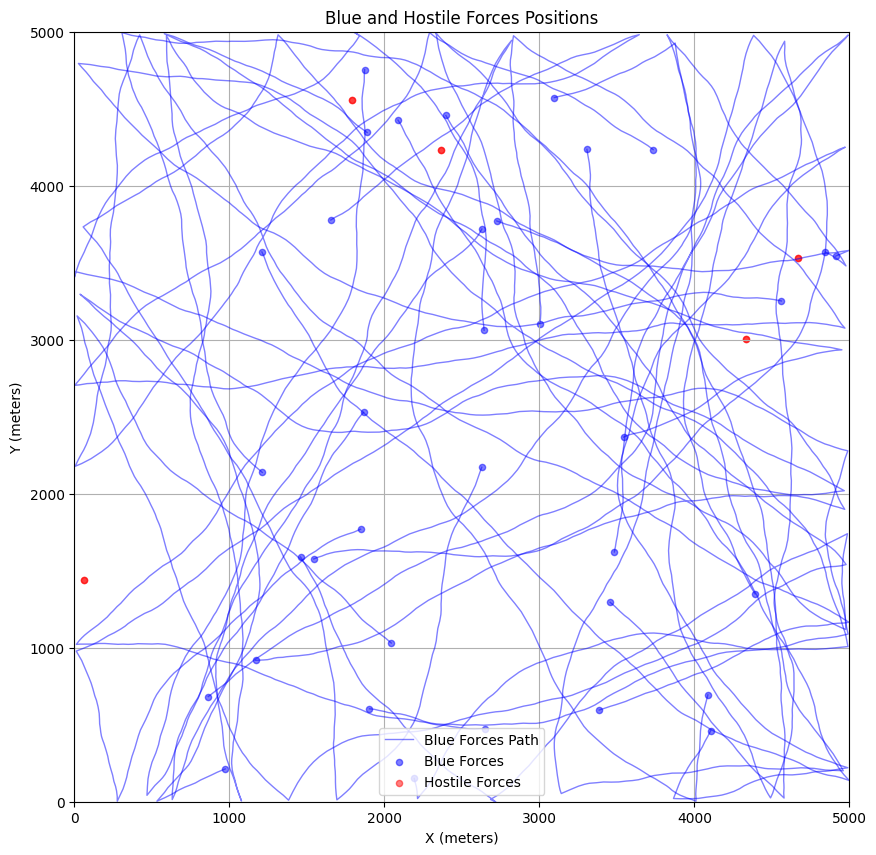

Global metrics saved as 'global_metrics.csv'
   Time  Security Parameter  Hostile Density  New Hostile Rate (min)  \
0     0              0.0000             0.24               720.00000   
1     1             -0.0024             0.24               720.00000   
2     2             -0.0048             0.24               719.98272   
3     3             -0.0072             0.24               719.96544   
4     4             -0.0096             0.24               719.94816   

   Attack Distance (m)  Blue Forces Removed  Hostile Forces Removed  \
0          4564.279821                    0                       0   
1          4516.759166                    0                       0   
2          4486.448349                    0                       0   
3          4448.667214                    0                       0   
4          4411.379708                    0                       0   

   Cumulative Patrol Distance (m)  
0                        0.000000  
1                      

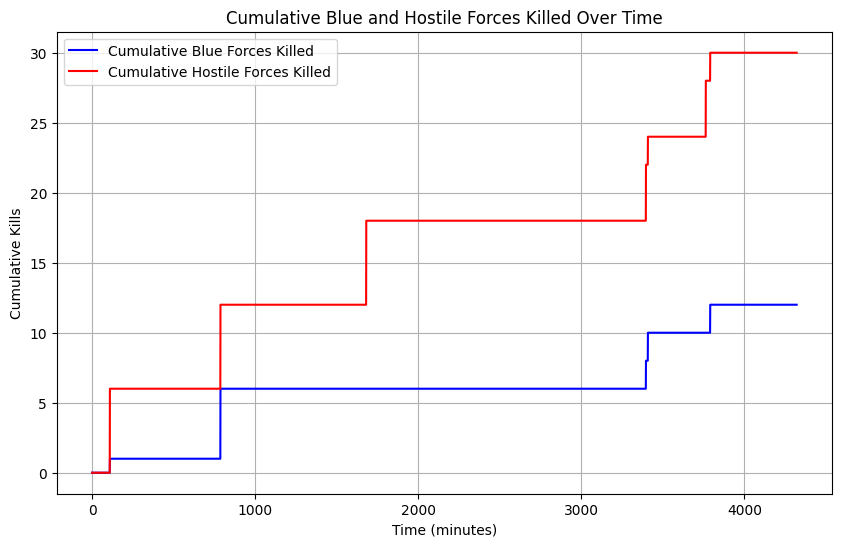

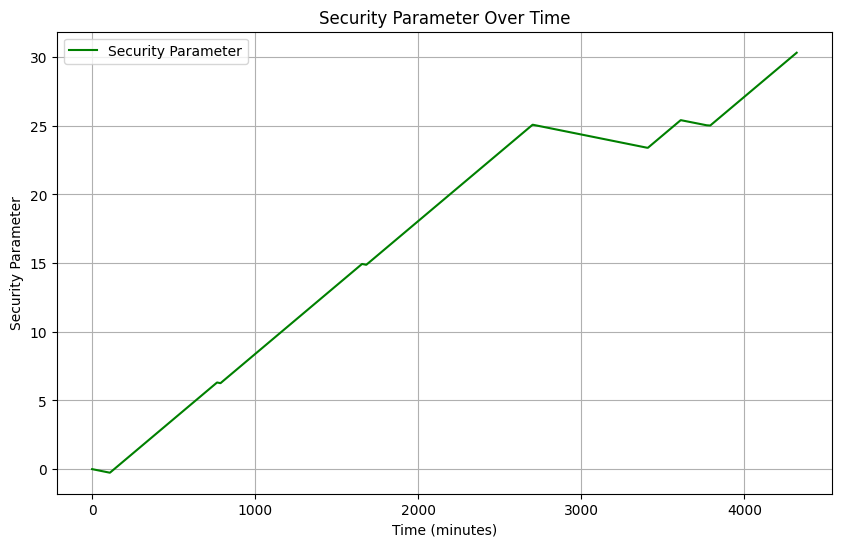

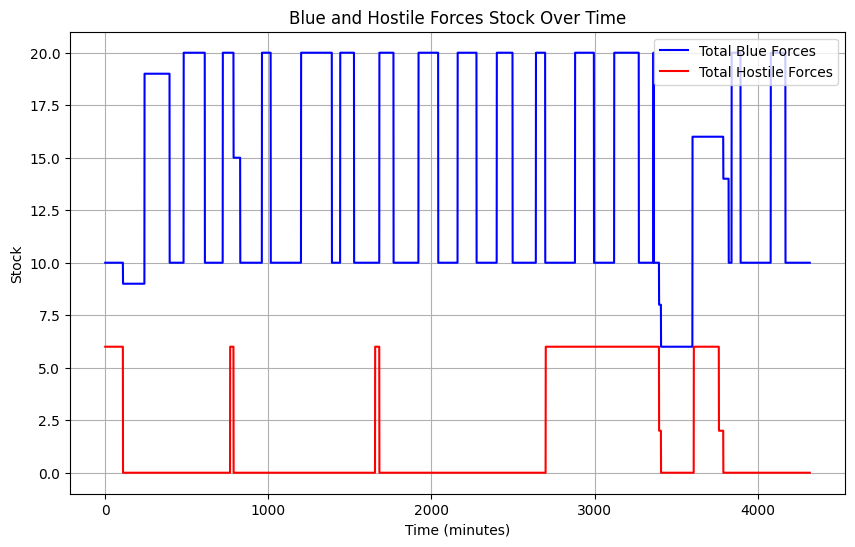

Simulation complete. Outputs saved.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, radians
import pandas as pd
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from IPython.display import display, clear_output
from math import exp

# Set random seed for reproducibility
np.random.seed(42)

# User input widgets
unit_size_slider = widgets.IntSlider(value=10, min=2, max=39, description='Blue Forces Stock:')
armor_dropdown = widgets.Dropdown(
    options=[
        ('Basilone Ballistic Insert', 8.3043963255),
        ('Chesty Ballistic Insert', 6.35042018586),
        ('Hathcock Ballistic Insert', 4.39644405)
    ],
    value=8.3043963255,
    description='Armor Load:'
)
terrain_inputs = {
    'paved': widgets.IntText(value=10, description='Paved (%):'),
    'dirt_road': widgets.IntText(value=10, description='Dirt Road (%):'),
    'light_brush': widgets.IntText(value=50, description='Light Brush (%):'),
    'heavy_brush': widgets.IntText(value=15, description='Heavy Brush (%):'),
    'loose_sand': widgets.IntText(value=15, description='Loose Sand (%):')
}
terrain_submit = widgets.Button(description='Submit Terrain')
direction_deviation_slider = widgets.FloatSlider(value=5, min=0, max=10, description='Direction Deviation:')
grade_std_slider = widgets.FloatSlider(value=10, min=0, max=20, description='Grade Std Dev:')
hostile_stock_slider = widgets.IntSlider(value=10, min=1, max=39, description='Hostile Stock:')
env_dropdown = widgets.Dropdown(
    options=['Krulak’s Three Block War', 'Pershing’s Ghost', 'Nightmare from Mattis Street'],
    value='Krulak’s Three Block War',
    description='Environment:'
)
blue_restock_slider = widgets.IntSlider(value=12, min=4, max=24, description='Blue Restock (hrs):')
hostile_restock_slider = widgets.IntSlider(value=12, min=4, max=24, description='Hostile Restock (hrs):')
run_button = widgets.Button(description='Run Simulation')

# Terrain validation
def validate_terrain(b):
    total = sum(t.value for t in terrain_inputs.values())
    if total != 100:
        print(f"Error: Terrain percentages must sum to 100, got {total}")
    else:
        print("Terrain percentages validated")
terrain_submit.on_click(validate_terrain)

# Display widgets once
display(unit_size_slider, armor_dropdown)
for t in terrain_inputs.values():
    display(t)
display(terrain_submit)
display(direction_deviation_slider, grade_std_slider, hostile_stock_slider, env_dropdown)
display(blue_restock_slider, hostile_restock_slider)
display(run_button)

# Simulation function
def run_simulation(b):
    try:
        clear_output(wait=True)
        # Initialize model parameters
        start_time = 0
        stop_time = 4320  # 3 days (72 hours)
        dt = 1  # 1 minute time step
        time_steps = np.arange(start_time, stop_time + dt, dt)

        # Validate and build terrain_types
        total = sum(t.value for t in terrain_inputs.values())
        if total != 100:
            print("Simulation aborted: Terrain percentages must sum to 100")
            return
        cumulative = 0
        terrain_types = {}
        for terrain_name, widget in terrain_inputs.items():
            low = cumulative + 1
            high = cumulative + widget.value
            eta = {'paved': 1.0, 'dirt_road': 1.1, 'light_brush': 1.2, 'heavy_brush': 1.5, 'loose_sand': 2.1}[terrain_name]
            terrain_types[terrain_name] = {'range': (low, high), 'eta': eta}
            cumulative = high

        # Blue Forces initialization
        blue_patrols = [{
            'stock': unit_size_slider.value,
            'x': np.random.uniform(0, 5000),
            'y': np.random.uniform(0, 5000),
            'direction': np.random.uniform(0, 360),
            'm': np.random.normal(76.6571, 11.06765),
            'spawn_time': 0,
            'removal_time': float('inf'),
            'positions': [],
            'stock_history': [],
            'direction_history': [],
            'P_history': [],
            'E_history': [],
            'exhaustion_reserve_history': [],
            'exhaustion_state_history': [0],
            'terrain_history': [],
            'v_history': [],
            'G_history': [],
            'blue_kills_history': [],
            'hostile_kills_history': [],
            'active': True
        }]
        blue_patrols[0]['positions'].append((blue_patrols[0]['x'], blue_patrols[0]['y']))
        blue_patrols[0]['stock_history'].append(blue_patrols[0]['stock'])
        blue_patrols[0]['direction_history'].append(blue_patrols[0]['direction'])
        blue_patrols[0]['blue_kills_history'].append(0)
        blue_patrols[0]['hostile_kills_history'].append(0)

        # Hostile Forces initialization
        hostile_patrols = [{
            'stock': hostile_stock_slider.value,
            'x': np.random.uniform(0, 5000),
            'y': np.random.uniform(0, 5000),
            'positions': [(np.random.uniform(0, 5000), np.random.uniform(0, 5000))],
            'stock_history': [],
            'blue_kills_history': [],
            'hostile_kills_history': [],
            'spawn_time': 0,
            'removal_time': float('inf')
        }]
        hostile_patrols[0]['stock_history'].append(hostile_stock_slider.value)
        hostile_patrols[0]['blue_kills_history'].append(0)
        hostile_patrols[0]['hostile_kills_history'].append(0)

        # Load parameter
        base_combat_load = 20.6497926
        L = base_combat_load + armor_dropdown.value

        # Security parameter
        security_parameter = 0
        security_history = [security_parameter]
        hostile_density_history = [hostile_patrols[0]['stock'] / 25]
        new_hostile_rate_history = [hostile_restock_slider.value * 60]
        attack_distance_history = []
        total_blue_kills_history = [0]
        total_hostile_kills_history = [0]
        cumulative_patrol_distance = 0
        cumulative_patrol_distance_history = [0]

        # Terrain change logic
        terrain_change_interval = np.random.randint(1, 11)
        terrain_change_counter = 0
        current_terrain = 'light_brush'
        current_eta = 1.2

        # Attack function
        def attack(blue_patrol, hostile_patrol, env):
            attack_distance = np.sqrt((blue_patrol['x'] - hostile_patrol['x'])**2 + (blue_patrol['y'] - hostile_patrol['y'])**2)
            if attack_distance > 1000:
                return 0, 0, attack_distance
            prob_attack = 1 / np.sqrt(attack_distance) if attack_distance > 0 else 1
            if np.random.random() > prob_attack:
                return 0, 0, attack_distance

            # Blue shots
            blue_shots = int(np.random.uniform(1, 16) * blue_patrol['stock'])
            prob_blue_hit = exp(-0.002 * attack_distance)
            blue_hits = sum(np.random.random() < prob_blue_hit for _ in range(blue_shots))
            blue_kills = min(
                hostile_patrol['stock'],
                sum(np.random.normal(0.75, 0.1) > np.random.random() for _ in range(blue_hits))
            )

            # Hostile shots
            hostile_shots = int(np.random.uniform(1, 11) * hostile_patrol['stock'])
            if env == 'Krulak’s Three Block War':
                prob_hostile_hit = exp(-0.004 * attack_distance)
                kill_mean = 0.5
            elif env == 'Pershing’s Ghost':
                prob_hostile_hit = exp(-0.003 * attack_distance)
                kill_mean = 0.625
            else:  # Nightmare from Mattis Street
                prob_hostile_hit = exp(-0.002 * attack_distance)
                kill_mean = 0.75
            hostile_hits = sum(np.random.random() < prob_hostile_hit for _ in range(hostile_shots))
            hostile_kills = min(
                blue_patrol['stock'],
                sum(np.random.normal(kill_mean, 0.1) > np.random.random() for _ in range(hostile_hits))
            )

            return blue_kills, hostile_kills, attack_distance

        # Simulation loop
        total_blue_stock_history = [sum(p['stock'] for p in blue_patrols)]
        total_hostile_stock_history = [sum(p['stock'] for p in hostile_patrols)]
        step_attack_distances = []
        step_blue_kills = 0
        step_hostile_kills = 0
        step_patrol_distance = 0
        for t in time_steps:
            # Initialize step variables
            step_attack_distances = []
            step_blue_kills = 0
            step_hostile_kills = 0
            step_patrol_distance = 0

            # Stop conditions
            total_hostile_stock = sum(p['stock'] for p in hostile_patrols)
            if t >= stop_time:
                print(f"Stopped at t={t}: Reached maximum time")
                break
            if security_parameter <= -100 or security_parameter >= 100:
                print(f"Stopped at t={t}: Security parameter reached {security_parameter}")
                break

            # Restocking
            if t > 0 and t % (blue_restock_slider.value * 60) == 0:
                new_patrol = {
                    'stock': unit_size_slider.value,
                    'x': np.random.uniform(0, 5000),
                    'y': np.random.uniform(0, 5000),
                    'direction': np.random.uniform(0, 360),
                    'm': np.random.normal(76.6571, 11.06765),
                    'spawn_time': t,
                    'removal_time': float('inf'),
                    'positions': [],
                    'stock_history': [],
                    'direction_history': [],
                    'P_history': [],
                    'E_history': [],
                    'exhaustion_reserve_history': [],
                    'exhaustion_state_history': [0],
                    'terrain_history': [],
                    'v_history': [],
                    'G_history': [],
                    'blue_kills_history': [],
                    'hostile_kills_history': [],
                    'active': True
                }
                new_patrol['positions'].append((new_patrol['x'], new_patrol['y']))
                new_patrol['stock_history'].append(new_patrol['stock'])
                new_patrol['direction_history'].append(new_patrol['direction'])
                new_patrol['blue_kills_history'].append(0)
                new_patrol['hostile_kills_history'].append(0)
                blue_patrols.append(new_patrol)

            base_hostile_rate = hostile_restock_slider.value * 60
            new_hostile_rate = base_hostile_rate + (base_hostile_rate * security_parameter / 100)
            new_hostile_rate_history.append(new_hostile_rate)
            if t > 0 and t % max(1, int(new_hostile_rate)) == 0:
                hostile_patrols.append({
                    'stock': hostile_stock_slider.value,
                    'x': np.random.uniform(0, 5000),
                    'y': np.random.uniform(0, 5000),
                    'positions': [(np.random.uniform(0, 5000), np.random.uniform(0, 5000))],
                    'stock_history': [hostile_stock_slider.value],
                    'blue_kills_history': [0],
                    'hostile_kills_history': [0],
                    'spawn_time': t,
                    'removal_time': float('inf')
                })

            # Update security parameter
            hostile_force_density = total_hostile_stock / 25
            hostile_density_history.append(hostile_force_density)
            if total_hostile_stock == 0:
                security_parameter = min(100, security_parameter + 0.01)
            else:
                security_parameter = max(-100, security_parameter - hostile_force_density / 100)
            security_history.append(security_parameter)

            # Process Blue Forces patrols
            for blue_patrol in blue_patrols:
                if not blue_patrol['active']:
                    blue_patrol['stock_history'].append(blue_patrol['stock'])
                    blue_patrol['P_history'].append(np.nan)
                    blue_patrol['E_history'].append(np.nan)
                    blue_patrol['exhaustion_reserve_history'].append(np.nan)
                    blue_patrol['terrain_history'].append(np.nan)
                    blue_patrol['v_history'].append(np.nan)
                    blue_patrol['G_history'].append(np.nan)
                    blue_patrol['direction_history'].append(np.nan)
                    blue_patrol['exhaustion_state_history'].append(blue_patrol['exhaustion_state_history'][-1])
                    blue_patrol['blue_kills_history'].append(0)
                    blue_patrol['hostile_kills_history'].append(0)
                    continue

                # Check exhaustion
                time_on_field = t - blue_patrol['spawn_time']
                exhaustion_threshold = max(0, (
                    -0.0841 * (time_on_field/60)**4 + 2.9025*(time_on_field/60)**3 -
                    41.059*(time_on_field/60)**2 + 195.14*(time_on_field/60) + 294.05
                ))
                total_exhaustion_state = blue_patrol['exhaustion_state_history'][-1]
                if total_exhaustion_state >= exhaustion_threshold:
                    blue_patrol['active'] = False
                    blue_patrol['stock'] = 0
                    blue_patrol['removal_time'] = t
                    blue_patrol['stock_history'].append(0)
                    blue_patrol['P_history'].append(np.nan)
                    blue_patrol['E_history'].append(np.nan)
                    blue_patrol['exhaustion_reserve_history'].append(np.nan)
                    blue_patrol['terrain_history'].append(np.nan)
                    blue_patrol['v_history'].append(np.nan)
                    blue_patrol['G_history'].append(np.nan)
                    blue_patrol['direction_history'].append(np.nan)
                    blue_patrol['exhaustion_state_history'].append(total_exhaustion_state)
                    blue_patrol['blue_kills_history'].append(0)
                    blue_patrol['hostile_kills_history'].append(0)
                    print(f"Blue Patrol removed at t={t}: Exhaustion threshold reached")
                    continue

                # Update direction
                deviation = direction_deviation_slider.value
                blue_patrol['direction'] = np.random.uniform(
                    blue_patrol['direction'] - deviation, blue_patrol['direction'] + deviation
                ) % 360
                blue_patrol['direction_history'].append(blue_patrol['direction'])

                # Update terrain
                terrain_change_counter += 1
                if terrain_change_counter >= terrain_change_interval:
                    terrain_roll = np.random.randint(1, 101)
                    for terrain_name, props in terrain_types.items():
                        low, high = props['range']
                        if low <= terrain_roll <= high:
                            current_terrain = terrain_name
                            current_eta = props['eta']
                            break
                    terrain_change_counter = 0
                    terrain_change_interval = np.random.randint(1, 11)
                blue_patrol['terrain_history'].append(current_terrain)

                # Speed factor based on terrain
                if current_terrain == 'paved':
                    v = np.random.uniform(0.8333325, 1.3888875)
                elif current_terrain == 'dirt_road':
                    v = np.random.uniform(0.66666675, 1.11111125)
                elif current_terrain in ['light_brush', 'heavy_brush']:
                    v = np.random.uniform(0.50000025, 0.83333375)
                else:  # loose_sand
                    v = np.random.uniform(0.333333, 0.555555)
                blue_patrol['v_history'].append(v)

                # Calculate movement distance
                move_distance = v * dt * 60  # v in m/s, dt in minutes, distance in meters
                step_patrol_distance += move_distance
                cumulative_patrol_distance += move_distance

                # Update position
                x_new = blue_patrol['x'] + move_distance * cos(radians(blue_patrol['direction']))
                y_new = blue_patrol['y'] + move_distance * sin(radians(blue_patrol['direction']))

                # Boundary checks
                if x_new < 0 or x_new > 5000:
                    blue_patrol['direction'] = (blue_patrol['direction'] + np.random.uniform(90, 180)) % 360
                    x_new = blue_patrol['x'] + move_distance * cos(radians(blue_patrol['direction']))
                    y_new = blue_patrol['y'] + move_distance * sin(radians(blue_patrol['direction']))
                if y_new < 0 or y_new > 5000:
                    blue_patrol['direction'] = (blue_patrol['direction'] + np.random.uniform(90, 180)) % 360
                    x_new = blue_patrol['x'] + move_distance * cos(radians(blue_patrol['direction']))
                    y_new = blue_patrol['y'] + move_distance * sin(radians(blue_patrol['direction']))

                blue_patrol['x'], blue_patrol['y'] = x_new, y_new
                blue_patrol['positions'].append((x_new, y_new))

                # Pandolf-Santee
                G = np.random.normal(0, grade_std_slider.value)
                blue_patrol['G_history'].append(G)
                D = 1 if G < 0 else 0
                P = (
                    1.5 * blue_patrol['m'] +
                    2.0 * (blue_patrol['m'] + L) * (L / blue_patrol['m'])**2 +
                    current_eta * (blue_patrol['m'] + L) * (1.5 * v**2 + 0.35 * v * G) -
                    D * current_eta * (
                        (G * v * (blue_patrol['m'] + L) / 3.5) -
                        ((blue_patrol['m'] + L) * (G + 6)**2 / blue_patrol['m']) +
                        (25 - v**2)
                    )
                )
                blue_patrol['P_history'].append(P)

                # Energy in Joules
                E = P * dt * 60
                blue_patrol['E_history'].append(E)

                # Exhaustion reserve
                exhaustion_reserve = max(0, E * 0.000239006 - (273.39 * dt / 60))
                blue_patrol['exhaustion_reserve_history'].append(exhaustion_reserve)

                # Total exhaustion state
                total_exhaustion_state = blue_patrol['exhaustion_state_history'][-1] + exhaustion_reserve
                blue_patrol['exhaustion_state_history'].append(total_exhaustion_state)

                blue_patrol['stock_history'].append(blue_patrol['stock'])
                blue_patrol['blue_kills_history'].append(0)
                blue_patrol['hostile_kills_history'].append(0)

            # Process attacks
            for blue_patrol in blue_patrols:
                if not blue_patrol['active']:
                    continue
                for hostile_patrol in hostile_patrols:
                    if hostile_patrol['stock'] <= 0:
                        if hostile_patrol['removal_time'] == float('inf'):
                            hostile_patrol['removal_time'] = t
                        hostile_patrol['stock_history'].append(hostile_patrol['stock'])
                        hostile_patrol['blue_kills_history'].append(0)
                        hostile_patrol['hostile_kills_history'].append(0)
                        continue
                    blue_kills, hostile_kills, attack_distance = attack(blue_patrol, hostile_patrol, env_dropdown.value)
                    step_attack_distances.append(attack_distance)
                    step_blue_kills += blue_kills
                    step_hostile_kills += hostile_kills
                    blue_patrol['blue_kills_history'][-1] += blue_kills
                    blue_patrol['hostile_kills_history'][-1] += hostile_kills
                    hostile_patrol['blue_kills_history'].append(blue_kills)
                    hostile_patrol['hostile_kills_history'].append(hostile_kills)
                    hostile_patrol['stock'] = max(0, hostile_patrol['stock'] - blue_kills)
                    blue_patrol['stock'] = max(0, blue_patrol['stock'] - hostile_kills)
                    hostile_patrol['stock_history'].append(hostile_patrol['stock'])
                    if blue_patrol['stock'] <= 0:
                        blue_patrol['active'] = False
                        blue_patrol['removal_time'] = t
                        blue_patrol['P_history'].append(np.nan)
                        blue_patrol['E_history'].append(np.nan)
                        blue_patrol['exhaustion_reserve_history'].append(np.nan)
                        blue_patrol['terrain_history'].append(np.nan)
                        blue_patrol['v_history'].append(np.nan)
                        blue_patrol['G_history'].append(np.nan)
                        blue_patrol['direction_history'].append(np.nan)
                        blue_patrol['exhaustion_state_history'].append(blue_patrol['exhaustion_state_history'][-1])
                        blue_patrol['blue_kills_history'].append(0)
                        blue_patrol['hostile_kills_history'].append(0)

            # Average attack distance and kills for the time step
            avg_attack_distance = np.mean(step_attack_distances) if step_attack_distances else np.nan
            attack_distance_history.append(avg_attack_distance)
            total_blue_kills_history.append(step_blue_kills)
            total_hostile_kills_history.append(step_hostile_kills)
            cumulative_patrol_distance_history.append(cumulative_patrol_distance)

            # Update total stock histories
            total_blue_stock_history.append(sum(p['stock'] for p in blue_patrols if p['active']))
            total_hostile_stock_history.append(sum(p['stock'] for p in hostile_patrols))

        # Truncate time_steps
        actual_steps = len(total_blue_stock_history)
        time_steps = np.arange(start_time, start_time + actual_steps * dt, dt)

        # Outputs
        # X,Y Location Plot
        plt.figure(figsize=(10, 10))
        has_blue_path = False
        has_blue_dots = False
        has_hostile_dots = False
        for i, blue_patrol in enumerate(blue_patrols):
            if blue_patrol['positions']:
                x_coords, y_coords = zip(*blue_patrol['positions'])
                # Plot path line
                plt.plot(x_coords, y_coords, 'b-', linewidth=1.0, alpha=0.5, label='Blue Forces Path' if not has_blue_path else '')
                has_blue_path = True
                # Plot start and end dots
                plt.scatter([x_coords[0], x_coords[-1]], [y_coords[0], y_coords[-1]], c='blue', s=20, alpha=0.5, label='Blue Forces' if not has_blue_dots else '')
                has_blue_dots = True
        for i, hostile_patrol in enumerate(hostile_patrols):
            if hostile_patrol['positions']:
                x_coords, y_coords = zip(*hostile_patrol['positions'])
                # Plot start and end dots (same for static hostiles)
                plt.scatter([x_coords[0], x_coords[-1]], [y_coords[0], y_coords[-1]], c='red', s=20, alpha=0.5, label='Hostile Forces' if not has_hostile_dots else '')
                has_hostile_dots = True
        plt.xlim(0, 5000)
        plt.ylim(0, 5000)
        plt.xlabel('X (meters)')
        plt.ylabel('Y (meters)')
        plt.title('Blue and Hostile Forces Positions')
        if has_blue_path or has_blue_dots or has_hostile_dots:
            plt.legend()
        plt.grid(True)
        plt.savefig('forces_path.png')
        plt.show()

        # X,Y Location Animation
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(0, 5000)
        ax.set_ylim(0, 5000)
        ax.set_xlabel('X (meters)')
        ax.set_ylabel('Y (meters)')
        ax.set_title('Forces Movement Animation')
        ax.grid(True)
        blue_points = []
        hostile_points = []
        blue_label = plt.Line2D([], [], marker='o', color='blue', markersize=5, label='Blue Forces')
        red_label = plt.Line2D([], [], marker='o', color='red', markersize=5, label='Hostile Forces')
        ax.legend(handles=[blue_label, red_label])

        def init():
            blue_points.clear()
            hostile_points.clear()
            return []

        def animate(i):
            t = i * dt  # Current time in minutes
            # Update blue_points
            while len(blue_points) < len(blue_patrols):
                blue_points.append(ax.plot([], [], 'o', c='blue', ms=5)[0])
            while len(blue_points) > len(blue_patrols):
                blue_points.pop().remove()

            # Update hostile_points
            while len(hostile_points) < len(hostile_patrols):
                hostile_points.append(ax.plot([], [], 'o', c='red', ms=5)[0])
            while len(hostile_points) > len(hostile_patrols):
                hostile_points.pop().remove()

            # Update Blue Forces positions
            for j, blue_patrol in enumerate(blue_patrols):
                if t >= blue_patrol['spawn_time'] and t <= blue_patrol['removal_time']:
                    pos_index = min(int(t - blue_patrol['spawn_time']), len(blue_patrol['positions']) - 1)
                    x_coords, y_coords = blue_patrol['positions'][pos_index]
                    blue_points[j].set_data([x_coords], [y_coords])
                else:
                    blue_points[j].set_data([], [])

            # Update Hostile Forces positions
            for j, hostile_patrol in enumerate(hostile_patrols):
                if t >= hostile_patrol['spawn_time'] and t <= hostile_patrol['removal_time'] and len(hostile_patrol['positions']) > 0:
                    x_coords, y_coords = hostile_patrol['positions'][0]
                    hostile_points[j].set_data([x_coords], [y_coords])
                else:
                    hostile_points[j].set_data([], [])

            return blue_points + hostile_points

        ani = FuncAnimation(fig, animate, init_func=init, frames=actual_steps, interval=50, blit=True)
        ani.save('forces_animation.mp4', writer='ffmpeg', fps=20)
        plt.close()

        # Global Metrics Table
        global_data = {
            'Time': time_steps,
            'Security Parameter': security_history + [np.nan] * (len(time_steps) - len(security_history)),
            'Hostile Density': hostile_density_history + [np.nan] * (len(time_steps) - len(hostile_density_history)),
            'New Hostile Rate (min)': new_hostile_rate_history + [np.nan] * (len(time_steps) - len(new_hostile_rate_history)),
            'Attack Distance (m)': attack_distance_history + [np.nan] * (len(time_steps) - len(attack_distance_history)),
            'Blue Forces Removed': total_hostile_kills_history + [np.nan] * (len(time_steps) - len(total_hostile_kills_history)),
            'Hostile Forces Removed': total_blue_kills_history + [np.nan] * (len(time_steps) - len(total_blue_kills_history)),
            'Cumulative Patrol Distance (m)': cumulative_patrol_distance_history + [np.nan] * (len(time_steps) - len(cumulative_patrol_distance_history))
        }
        global_df = pd.DataFrame(global_data)
        global_df.to_csv('global_metrics.csv', index=False)
        print("Global metrics saved as 'global_metrics.csv'")
        print(global_df.head())

        # Per-Patrol Metrics Table
        per_patrol_data = {'Time': time_steps}
        for i, blue_patrol in enumerate(blue_patrols):
            prefix = f'Patrol {i+1}'
            per_patrol_data.update({
                f'Power (W) {prefix}': blue_patrol['P_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['P_history'])),
                f'Energy (J) {prefix}': blue_patrol['E_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['E_history'])),
                f'Exhaustion Reserve {prefix}': blue_patrol['exhaustion_reserve_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['exhaustion_reserve_history'])),
                f'Terrain Type {prefix}': blue_patrol['terrain_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['terrain_history'])),
                f'Speed (m/s) {prefix}': blue_patrol['v_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['v_history'])),
                f'Grade (%) {prefix}': blue_patrol['G_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['G_history'])),
                f'Direction (deg) {prefix}': blue_patrol['direction_history'][1:] + [np.nan] * (len(time_steps) - len(blue_patrol['direction_history'][1:])),
                f'Blue Kills {prefix}': blue_patrol['blue_kills_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['blue_kills_history'])),
                f'Hostile Kills {prefix}': blue_patrol['hostile_kills_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['hostile_kills_history']))
            })
        per_patrol_df = pd.DataFrame(per_patrol_data)
        per_patrol_df.to_csv('per_patrol_metrics.csv', index=False)
        print("Per-patrol metrics saved as 'per_patrol_metrics.csv'")
        print(per_patrol_df.head())

        # Cumulative Kills Plot
        cumulative_blue_kills = np.cumsum(total_hostile_kills_history)
        cumulative_hostile_kills = np.cumsum(total_blue_kills_history)
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps[:len(cumulative_blue_kills)], cumulative_blue_kills, 'b-', label='Cumulative Blue Forces Killed')
        plt.plot(time_steps[:len(cumulative_hostile_kills)], cumulative_hostile_kills, 'r-', label='Cumulative Hostile Forces Killed')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Cumulative Kills')
        plt.title('Cumulative Blue and Hostile Forces Killed Over Time')
        plt.legend()
        plt.grid(True)
        plt.savefig('cumulative_kills.png')
        plt.show()

        # Security Parameter Plot
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps[:len(security_history)], security_history, 'g-', label='Security Parameter')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Security Parameter')
        plt.title('Security Parameter Over Time')
        plt.legend()
        plt.grid(True)
        plt.savefig('security_parameter.png')
        plt.show()

        # Stock History Plot
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps, total_blue_stock_history, 'b-', label='Total Blue Forces')
        plt.plot(time_steps, total_hostile_stock_history, 'r-', label='Total Hostile Forces')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Stock')
        plt.title('Blue and Hostile Forces Stock Over Time')
        plt.legend()
        plt.grid(True)
        plt.savefig('stock_history.png')
        plt.show()

        print("Simulation complete. Outputs saved.")

    except Exception as e:
        print(f"Simulation failed: {str(e)}")

# Register button event
run_button.on_click(run_simulation)

# Project Version 3

Blue Patrol removed at t=1003: Exhaustion threshold reached
Blue Patrol removed at t=1558: Exhaustion threshold reached
Blue Patrol removed at t=2824: Exhaustion threshold reached
Stopped at t=4320: Reached maximum time


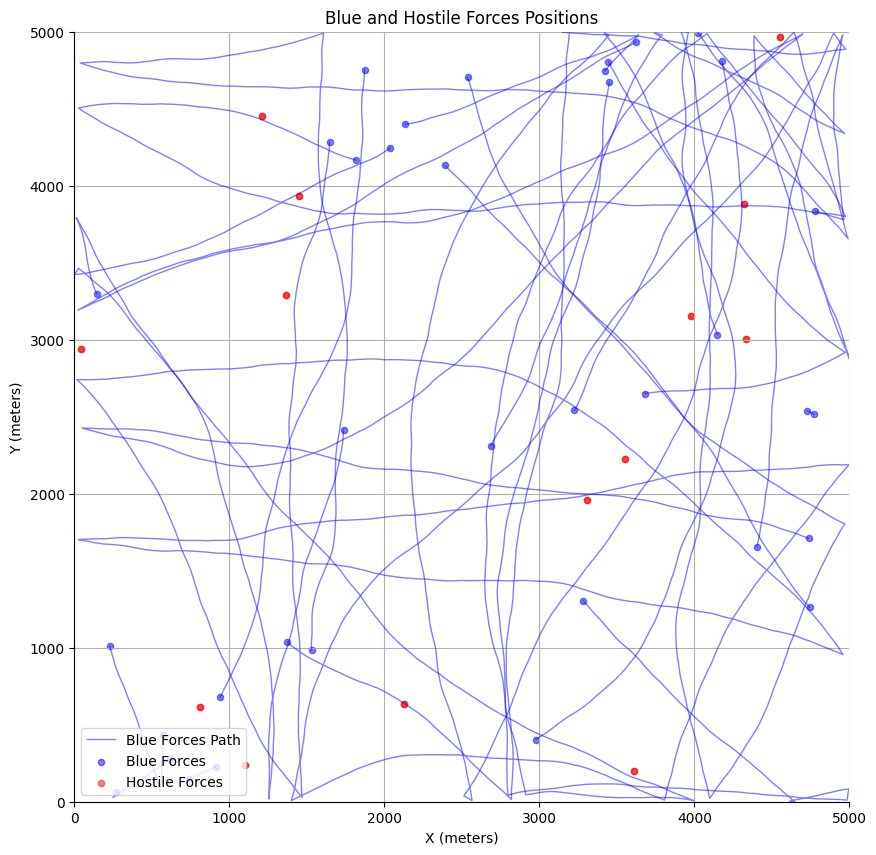

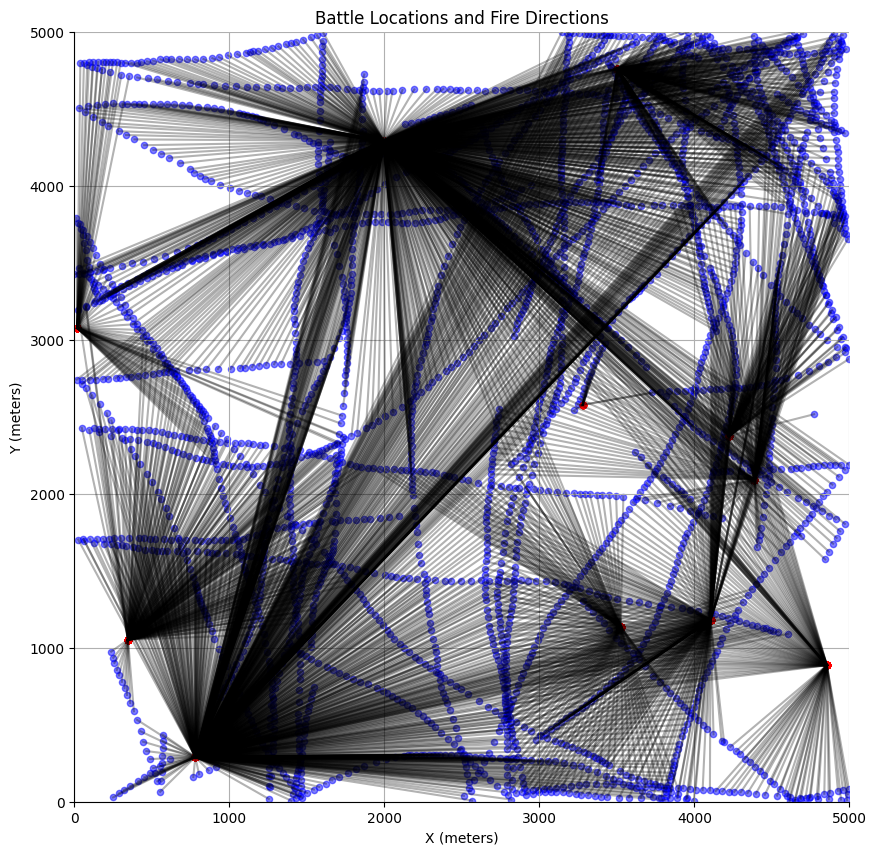

Attack line at t=0: Blue (1870.002041731918, 4722.5604762036855) to Hostile (779.9726016810132, 290.4180608409973)
Attack line at t=1: Blue (1867.65928365931, 4673.845698270406) to Hostile (779.9726016810132, 290.4180608409973)
Attack line at t=2: Blue (1863.5870386607392, 4643.657862826493) to Hostile (779.9726016810132, 290.4180608409973)
Attack line at t=3: Blue (1858.6702112354465, 4605.98008507093) to Hostile (779.9726016810132, 290.4180608409973)
Attack line at t=4: Blue (1854.5707755986136, 4568.554675195402) to Hostile (779.9726016810132, 290.4180608409973)
Attack line at t=5: Blue (1853.5968743472185, 4529.231455910629) to Hostile (779.9726016810132, 290.4180608409973)
Attack line at t=6: Blue (1852.5861699867464, 4498.983022401537) to Hostile (779.9726016810132, 290.4180608409973)
Attack line at t=7: Blue (1855.3365981168843, 4436.196081888813) to Hostile (779.9726016810132, 290.4180608409973)
Attack line at t=8: Blue (1860.2311825785168, 4358.57716704618) to Hostile (779.972

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, radians
import pandas as pd
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from IPython.display import display, clear_output
from math import exp

# Set random seed for reproducibility
np.random.seed(42)

# Threat library
threat_library = {
    'Garnet': [0.0011, -2.9354, 2844.8],
    'Amethyst': [0.0017, -4.2007, 3167.4],
    'Aquamarine': [0.001, -2.8943, 2836.6],
    'Diamond': [0.0007, -2.4645, 2777.8],
    'Emerald': [0.001, -2.8219, 2765.7],
    'Pearl': [0.0009, -2.524, 2746.6],
    'Ruby': [0.0009, -2.5037, 2745.5],
    'Peridot': [0.0026, -4.0108, 2356.4],
    'Sapphire': [0.0018, -3.6389, 2334.7],
    'Opal': [0.0016, -4.1357, 3163.8],
    'Topaz': [0.0015, -4.0872, 3160.6],
    'Zircon': [0.0007, -2.4835, 2782.8],
    'Batman': [0.0008, -2.5456, 2852.4],
    'Robin': [0.0014, -3.4839, 2374.9]
}

# Operational environment threat probabilities
krulak_threat_probs = {
    'Garnet': 0.01, 'Amethyst': 0, 'Aquamarine': 0, 'Diamond': 0.04, 'Emerald': 0,
    'Pearl': 0.45, 'Ruby': 0.15, 'Peridot': 0.15, 'Sapphire': 0.15, 'Opal': 0.05,
    'Topaz': 0, 'Zircon': 0
}
pershing_threat_probs = {
    'Garnet': 0.10, 'Amethyst': 0.02, 'Aquamarine': 0.01, 'Diamond': 0.10, 'Emerald': 0,
    'Pearl': 0.20, 'Ruby': 0.05, 'Peridot': 0.25, 'Sapphire': 0.15, 'Opal': 0.08,
    'Topaz': 0.04, 'Zircon': 0
}
mattis_threat_probs = {
    'Garnet': 0.34, 'Amethyst': 0.11, 'Aquamarine': 0.09, 'Diamond': 0.10, 'Emerald': 0.04,
    'Pearl': 0.05, 'Ruby': 0.05, 'Peridot': 0.05, 'Sapphire': 0.01, 'Opal': 0.05,
    'Topaz': 0.10, 'Zircon': 0.01
}
blue_threat_probs = {'Batman': 0.5, 'Robin': 0.5}
threat_probs = {
    'Krulak’s Three Block War': krulak_threat_probs,
    'Pershing’s Ghost': pershing_threat_probs,
    'Nightmare from Mattis Street': mattis_threat_probs
}

# Armor profiles
armor_profiles = {
    'Basilone Ballistic Insert': {
        'Garnet': [-15, 0.004], 'Amethyst': [-17, 0.004], 'Aquamarine': [-14, 0.004],
        'Diamond': [-15, 0.004], 'Emerald': [-12, 0.004], 'Pearl': [-25, 0.004],
        'Ruby': [-25, 0.004], 'Peridot': [-14, 0.004], 'Sapphire': [-25, 0.004],
        'Opal': [-25, 0.004], 'Topaz': [-20, 0.004], 'Zircon': [-8, 0.004]
    },
    'Chesty Ballistic Insert': {
        'Garnet': [-14, 0.004], 'Amethyst': [-10, 0.004], 'Aquamarine': [-8, 0.004],
        'Diamond': [-13, 0.004], 'Emerald': [-4, 0.004], 'Pearl': [-25, 0.004],
        'Ruby': [-25, 0.004], 'Peridot': [-13, 0.004], 'Sapphire': [-25, 0.004],
        'Opal': [-25, 0.004], 'Topaz': [-16, 0.004], 'Zircon': [-2, 0.004]
    },
    'Hathcock Ballistic Insert': {
        'Garnet': [-8, 0.004], 'Amethyst': [-6, 0.004], 'Aquamarine': [-4, 0.004],
        'Diamond': [-9, 0.004], 'Emerald': [-2, 0.004], 'Pearl': [-20, 0.004],
        'Ruby': [-25, 0.004], 'Peridot': [-10, 0.004], 'Sapphire': [-12, 0.004],
        'Opal': [-22, 0.004], 'Topaz': [-11, 0.004], 'Zircon': [-1, 0.004]
    },
    'Hostile Basilone (Mattis)': {
        'Batman': [-8, 0.004], 'Robin': [-12, 0.004]
    }
}

# User input widgets
unit_size_slider = widgets.IntSlider(value=10, min=2, max=39, description='Blue Forces Stock:')
armor_dropdown = widgets.Dropdown(
    options=[
        ('Basilone Ballistic Insert', 8.3043963255),
        ('Chesty Ballistic Insert', 6.35042018586),
        ('Hathcock Ballistic Insert', 4.39644405)
    ],
    value=8.3043963255,
    description='Armor Load:'
)
terrain_inputs = {
    'paved': widgets.IntText(value=10, description='Paved (%):'),
    'dirt_road': widgets.IntText(value=10, description='Dirt Road (%):'),
    'light_brush': widgets.IntText(value=50, description='Light Brush (%):'),
    'heavy_brush': widgets.IntText(value=15, description='Heavy Brush (%):'),
    'loose_sand': widgets.IntText(value=15, description='Loose Sand (%):')
}
terrain_submit = widgets.Button(description='Submit Terrain')
direction_deviation_slider = widgets.FloatSlider(value=5, min=0, max=10, description='Direction Deviation:')
grade_std_slider = widgets.FloatSlider(value=10, min=0, max=20, description='Grade Std Dev:')
hostile_stock_slider = widgets.IntSlider(value=10, min=1, max=39, description='Hostile Stock:')
env_dropdown = widgets.Dropdown(
    options=['Krulak’s Three Block War', 'Pershing’s Ghost', 'Nightmare from Mattis Street'],
    value='Krulak’s Three Block War',
    description='Environment:'
)
blue_restock_slider = widgets.IntSlider(value=12, min=4, max=24, description='Blue Restock (hrs):')
hostile_restock_slider = widgets.IntSlider(value=12, min=4, max=24, description='Hostile Restock (hrs):')
blue_min_fire_rate = widgets.IntSlider(value=1, min=0, max=25, description='Blue Min Fire Rate:')
blue_max_fire_rate = widgets.IntSlider(value=15, min=0, max=25, description='Blue Max Fire Rate:')
hostile_min_fire_rate = widgets.IntSlider(value=1, min=0, max=25, description='Hostile Min Fire Rate:')
hostile_max_fire_rate = widgets.IntSlider(value=10, min=0, max=25, description='Hostile Max Fire Rate:')
save_per_patrol = widgets.Dropdown(options=['Yes', 'No'], value='Yes', description='Save Per-Patrol Data:')
run_button = widgets.Button(description='Run Simulation')
verbose = True

# Terrain validation
def validate_terrain(b):
    total = sum(t.value for t in terrain_inputs.values())
    if total != 100:
        if verbose:
            print(f"Error: Terrain percentages must sum to 100, got {total}")
    else:
        if verbose:
            print("Terrain percentages validated")
terrain_submit.on_click(validate_terrain)

# Display widgets once
display(unit_size_slider, armor_dropdown)
for t in terrain_inputs.values():
    display(t)
display(terrain_submit)
display(direction_deviation_slider, grade_std_slider, hostile_stock_slider, env_dropdown)
display(blue_restock_slider, hostile_restock_slider)
display(blue_min_fire_rate, blue_max_fire_rate, hostile_min_fire_rate, hostile_max_fire_rate)
display(save_per_patrol)
display(run_button)

# Utility functions
def get_velocity(threat, distance):
    c1, c2, c3 = threat_library[threat]
    return c1 * distance**2 + c2 * distance + c3

def get_defeat_probability(armor, threat, velocity):
    beta0, beta1 = armor_profiles[armor][threat]
    exponent = beta0 + velocity * beta1
    return np.exp(exponent) / (1 + np.exp(exponent))

# Simulation function
def run_simulation(b):
    try:
        clear_output(wait=True)
        # Initialize model parameters
        start_time = 0
        stop_time = 4320  # 3 days
        dt = 1  # 1 minute time step
        time_steps = np.arange(start_time, stop_time + dt, dt)

        # Validate terrain
        total = sum(t.value for t in terrain_inputs.values())
        if total != 100:
            if verbose:
                print("Simulation aborted: Terrain percentages must sum to 100")
            return
        cumulative = 0
        terrain_types = {}
        for terrain_name, widget in terrain_inputs.items():
            low = cumulative + 1
            high = cumulative + widget.value
            eta = {'paved': 1.0, 'dirt_road': 1.1, 'light_brush': 1.2, 'heavy_brush': 1.5, 'loose_sand': 2.1}[terrain_name]
            terrain_types[terrain_name] = {'range': (low, high), 'eta': eta}
            cumulative = high

        # Blue Forces initialization
        blue_patrols = [{
            'stock': unit_size_slider.value,
            'x': np.random.uniform(0, 5000),
            'y': np.random.uniform(0, 5000),
            'direction': np.random.uniform(0, 360),
            'm': np.random.normal(76.6571, 11.06765),
            'spawn_time': 0,
            'removal_time': float('inf'),
            'positions': [],
            'stock_history': [],
            'direction_history': [],
            'P_history': [],
            'E_history': [],
            'total_energy': 0,
            'percent_exhausted_history': [],
            'terrain_history': [],
            'v_history': [],
            'G_history': [],
            'blue_kills_history': [],
            'hostile_kills_history': [],
            'active': True
        }]
        blue_patrols[0]['positions'].append((blue_patrols[0]['x'], blue_patrols[0]['y']))
        blue_patrols[0]['stock_history'].append(blue_patrols[0]['stock'])
        blue_patrols[0]['direction_history'].append(blue_patrols[0]['direction'])
        blue_patrols[0]['blue_kills_history'].append(0)
        blue_patrols[0]['hostile_kills_history'].append(0)
        blue_patrols[0]['percent_exhausted_history'].append(0)

        # Hostile Forces initialization
        hostile_patrols = [{
            'stock': hostile_stock_slider.value,
            'x': np.random.uniform(0, 5000),
            'y': np.random.uniform(0, 5000),
            'positions': [(np.random.uniform(0, 5000), np.random.uniform(0, 5000))],
            'stock_history': [],
            'blue_kills_history': [],
            'hostile_kills_history': [],
            'spawn_time': 0,
            'removal_time': float('inf')
        }]
        hostile_patrols[0]['stock_history'].append(hostile_stock_slider.value)
        hostile_patrols[0]['blue_kills_history'].append(0)
        hostile_patrols[0]['hostile_kills_history'].append(0)

        # Load parameter
        base_combat_load = 20.6497926
        L = base_combat_load + armor_dropdown.value

        # Security parameter
        security_parameter = 0
        security_history = [security_parameter]
        hostile_density_history = [hostile_patrols[0]['stock'] / 25]
        blue_density_history = [blue_patrols[0]['stock'] / 25]
        new_hostile_rate_history = [hostile_restock_slider.value * 60]
        attack_distance_history = []
        total_blue_kills_history = [0]
        total_hostile_kills_history = [0]
        cumulative_patrol_distance = 0
        cumulative_patrol_distance_history = [0]
        attack_data = []  # Store attack details: (time, blue_x, blue_y, hostile_x, hostile_y)

        # Terrain change logic
        terrain_change_interval = np.random.randint(1, 11)
        terrain_change_counter = 0
        current_terrain = 'light_brush'
        current_eta = 1.2

        # Attack function
        def attack(blue_patrol, hostile_patrol, env, armor, distance):
            if distance > 1000:
                return 0, 0, distance
            prob_attack = min(1, 1 / np.sqrt(distance) if distance > 0 else 1 + security_parameter / 100)
            if np.random.random() > prob_attack:
                return 0, 0, distance

            # Blue shots
            blue_shots = np.random.randint(blue_min_fire_rate.value, blue_max_fire_rate.value + 1) * blue_patrol['stock']
            blue_threat = np.random.choice(['Batman', 'Robin'], p=[0.5, 0.5])
            blue_velocity = get_velocity(blue_threat, distance)
            if env == 'Krulak’s Three Block War':
                prob_blue_hit = exp(-0.004 * distance)
            elif env == 'Pershing’s Ghost':
                prob_blue_hit = exp(-0.003 * distance)
            else:  # Nightmare from Mattis Street
                prob_blue_hit = exp(-0.002 * distance)
            blue_hits = sum(np.random.random() < prob_blue_hit for _ in range(blue_shots))
            if env == 'Nightmare from Mattis Street':
                blue_defeats = sum(np.random.random() < get_defeat_probability('Hostile Basilone (Mattis)', blue_threat, blue_velocity) for _ in range(blue_hits))
                hostile_kills = min(hostile_patrol['stock'], sum(np.random.normal(0.75, 0.05) > np.random.random() for _ in range(blue_defeats)))
            else:
                hostile_kills = min(hostile_patrol['stock'], sum(np.random.normal(0.75, 0.05) > np.random.random() for _ in range(blue_hits)))

            # Hostile shots
            hostile_shots = np.random.randint(hostile_min_fire_rate.value, hostile_max_fire_rate.value + 1) * hostile_patrol['stock']
            hostile_threat = np.random.choice(list(threat_probs[env].keys()), p=list(threat_probs[env].values()))
            hostile_velocity = get_velocity(hostile_threat, distance)
            if env == 'Krulak’s Three Block War':
                prob_hostile_hit = exp(-0.004 * distance)
            elif env == 'Pershing’s Ghost':
                prob_hostile_hit = exp(-0.003 * distance)
            else:  # Nightmare from Mattis Street
                prob_hostile_hit = exp(-0.002 * distance)
            hostile_hits = sum(np.random.random() < prob_hostile_hit for _ in range(hostile_shots))
            hostile_defeats = sum(np.random.random() < get_defeat_probability(armor, hostile_threat, hostile_velocity) for _ in range(hostile_hits))
            blue_kills = min(blue_patrol['stock'], sum(np.random.normal(0.75, 0.05) > np.random.random() for _ in range(hostile_defeats)))

            return blue_kills, hostile_kills, distance

        # Simulation loop
        total_blue_stock_history = [sum(p['stock'] for p in blue_patrols)]
        total_hostile_stock_history = [sum(p['stock'] for p in hostile_patrols)]
        for t in time_steps:
            # Initialize step variables
            step_attack_distances = []
            step_blue_kills = 0
            step_hostile_kills = 0
            step_patrol_distance = 0

            # Stop conditions
            total_hostile_stock = sum(p['stock'] for p in hostile_patrols)
            total_blue_stock = sum(p['stock'] for p in blue_patrols)
            if t >= stop_time:
                if verbose:
                    print(f"Stopped at t={t}: Reached maximum time")
                break
            if security_parameter <= -100 or security_parameter >= 100:
                if verbose:
                    print(f"Stopped at t={t}: Security parameter reached {security_parameter}")
                break

            # Restocking
            if t > 0 and t % (blue_restock_slider.value * 60) == 0:
                new_patrol = {
                    'stock': unit_size_slider.value,
                    'x': np.random.uniform(0, 5000),
                    'y': np.random.uniform(0, 5000),
                    'direction': np.random.uniform(0, 360),
                    'm': np.random.normal(76.6571, 11.06765),
                    'spawn_time': t,
                    'removal_time': float('inf'),
                    'positions': [],
                    'stock_history': [],
                    'direction_history': [],
                    'P_history': [],
                    'E_history': [],
                    'total_energy': 0,
                    'percent_exhausted_history': [],
                    'terrain_history': [],
                    'v_history': [],
                    'G_history': [],
                    'blue_kills_history': [],
                    'hostile_kills_history': [],
                    'active': True
                }
                new_patrol['positions'].append((new_patrol['x'], new_patrol['y']))
                new_patrol['stock_history'].append(new_patrol['stock'])
                new_patrol['direction_history'].append(new_patrol['direction'])
                new_patrol['blue_kills_history'].append(0)
                new_patrol['hostile_kills_history'].append(0)
                new_patrol['percent_exhausted_history'].append(0)
                blue_patrols.append(new_patrol)

            base_hostile_rate = hostile_restock_slider.value * 60
            new_hostile_rate = base_hostile_rate + (base_hostile_rate * security_parameter / 100)
            new_hostile_rate_history.append(new_hostile_rate)
            if t > 0 and t % max(1, int(new_hostile_rate)) == 0:
                hostile_patrols.append({
                    'stock': hostile_stock_slider.value,
                    'x': np.random.uniform(0, 5000),
                    'y': np.random.uniform(0, 5000),
                    'positions': [(np.random.uniform(0, 5000), np.random.uniform(0, 5000))],
                    'stock_history': [hostile_stock_slider.value],
                    'blue_kills_history': [0],
                    'hostile_kills_history': [0],
                    'spawn_time': t,
                    'removal_time': float('inf')
                })

            # Update security parameter
            hostile_force_density = total_hostile_stock / 25
            blue_force_density = total_blue_stock / 25
            hostile_density_history.append(hostile_force_density)
            blue_density_history.append(blue_force_density)
            security_parameter = security_parameter + ((blue_force_density - hostile_force_density) / 100)
            security_history.append(security_parameter)

            # Process Blue Forces patrols
            for blue_patrol in blue_patrols:
                if not blue_patrol['active']:
                    blue_patrol['stock_history'].append(blue_patrol['stock'])
                    blue_patrol['P_history'].append(np.nan)
                    blue_patrol['E_history'].append(np.nan)
                    blue_patrol['percent_exhausted_history'].append(np.nan)
                    blue_patrol['terrain_history'].append(np.nan)
                    blue_patrol['v_history'].append(np.nan)
                    blue_patrol['G_history'].append(np.nan)
                    blue_patrol['direction_history'].append(np.nan)
                    blue_patrol['blue_kills_history'].append(0)
                    blue_patrol['hostile_kills_history'].append(0)
                    continue

                # Check exhaustion
                time_on_field = t - blue_patrol['spawn_time']
                hours = (t - blue_patrol['spawn_time']) / 60
                avg_patrol_power = (blue_patrol['total_energy'] * 0.000239006) / max(hours, 1e-6)
                exhaustion_line = 715.01536929919 * hours**(-0.386900198932066) if hours > 0 else float('inf')
                percent_exhausted = avg_patrol_power / exhaustion_line if exhaustion_line > 0 else 0
                blue_patrol['percent_exhausted_history'].append(percent_exhausted)
                if avg_patrol_power >= exhaustion_line:
                    blue_patrol['active'] = False
                    blue_patrol['stock'] = 0
                    blue_patrol['removal_time'] = t
                    blue_patrol['stock_history'].append(0)
                    blue_patrol['P_history'].append(np.nan)
                    blue_patrol['E_history'].append(np.nan)
                    blue_patrol['percent_exhausted_history'].append(np.nan)
                    blue_patrol['terrain_history'].append(np.nan)
                    blue_patrol['v_history'].append(np.nan)
                    blue_patrol['G_history'].append(np.nan)
                    blue_patrol['direction_history'].append(np.nan)
                    blue_patrol['blue_kills_history'].append(0)
                    blue_patrol['hostile_kills_history'].append(0)
                    if verbose:
                        print(f"Blue Patrol removed at t={t}: Exhaustion threshold reached")
                    continue

                # Update direction
                deviation = direction_deviation_slider.value
                blue_patrol['direction'] = np.random.uniform(
                    blue_patrol['direction'] - deviation, blue_patrol['direction'] + deviation
                ) % 360
                blue_patrol['direction_history'].append(blue_patrol['direction'])

                # Update terrain
                terrain_change_counter += 1
                if terrain_change_counter >= terrain_change_interval:
                    terrain_roll = np.random.randint(1, 101)
                    for terrain_name, props in terrain_types.items():
                        low, high = props['range']
                        if low <= terrain_roll <= high:
                            current_terrain = terrain_name
                            current_eta = props['eta']
                            break
                    terrain_change_counter = 0
                    terrain_change_interval = np.random.randint(1, 11)
                blue_patrol['terrain_history'].append(current_terrain)

                # Speed factor based on terrain
                if current_terrain == 'paved':
                    v = np.random.uniform(0.8333325, 1.3888875)
                elif current_terrain == 'dirt_road':
                    v = np.random.uniform(0.66666675, 1.11111125)
                elif current_terrain in ['light_brush', 'heavy_brush']:
                    v = np.random.uniform(0.50000025, 0.83333375)
                else:  # loose_sand
                    v = np.random.uniform(0.333333, 0.555555)
                blue_patrol['v_history'].append(v)

                # Calculate movement distance
                move_distance = v * dt * 60  # v in m/s, dt in minutes, distance in meters
                step_patrol_distance += move_distance
                cumulative_patrol_distance += move_distance

                # Update position
                x_new = blue_patrol['x'] + move_distance * cos(radians(blue_patrol['direction']))
                y_new = blue_patrol['y'] + move_distance * sin(radians(blue_patrol['direction']))

                # Boundary checks
                if x_new < 0 or x_new > 5000:
                    blue_patrol['direction'] = (blue_patrol['direction'] + np.random.uniform(90, 180)) % 360
                    x_new = blue_patrol['x'] + move_distance * cos(radians(blue_patrol['direction']))
                    y_new = blue_patrol['y'] + move_distance * sin(radians(blue_patrol['direction']))
                if y_new < 0 or y_new > 5000:
                    blue_patrol['direction'] = (blue_patrol['direction'] + np.random.uniform(90, 180)) % 360
                    x_new = blue_patrol['x'] + move_distance * cos(radians(blue_patrol['direction']))
                    y_new = blue_patrol['y'] + move_distance * sin(radians(blue_patrol['direction']))

                blue_patrol['x'], blue_patrol['y'] = x_new, y_new
                blue_patrol['positions'].append((x_new, y_new))

                # Pandolf-Santee
                G = np.random.normal(0, grade_std_slider.value)
                blue_patrol['G_history'].append(G)
                D = 1 if G < 0 else 0
                P = (
                    1.5 * blue_patrol['m'] +
                    2.0 * (blue_patrol['m'] + L) * (L / blue_patrol['m'])**2 +
                    current_eta * (blue_patrol['m'] + L) * (1.5 * v**2 + 0.35 * v * G) -
                    D * current_eta * (
                        (G * v * (blue_patrol['m'] + L) / 3.5) -
                        ((blue_patrol['m'] + L) * (G + 6)**2 / blue_patrol['m']) +
                        (25 - v**2)
                    )
                )
                blue_patrol['P_history'].append(P)

                # Energy in Joules
                E = P * dt * 60
                blue_patrol['E_history'].append(E)
                blue_patrol['total_energy'] += E

                blue_patrol['stock_history'].append(blue_patrol['stock'])
                blue_patrol['blue_kills_history'].append(0)
                blue_patrol['hostile_kills_history'].append(0)

            # Process attacks (one per time step, closest pair)
            min_distance = float('inf')
            attack_pair = None
            for blue_patrol in blue_patrols:
                if not blue_patrol['active']:
                    continue
                for hostile_patrol in hostile_patrols:
                    if hostile_patrol['stock'] <= 0:
                        continue
                    distance = np.sqrt((blue_patrol['x'] - hostile_patrol['x'])**2 + (blue_patrol['y'] - hostile_patrol['y'])**2)
                    if distance < min_distance:
                        min_distance = distance
                        attack_pair = (blue_patrol, hostile_patrol)

            if attack_pair:
                blue_patrol, hostile_patrol = attack_pair
                # Use selected armor type
                armor_type = armor_dropdown.options[armor_dropdown.index][0]
                blue_kills, hostile_kills, attack_distance = attack(blue_patrol, hostile_patrol, env_dropdown.value, armor_type, min_distance)
                step_attack_distances.append(attack_distance)
                step_blue_kills += blue_kills
                step_hostile_kills += hostile_kills
                blue_patrol['blue_kills_history'][-1] += blue_kills
                blue_patrol['hostile_kills_history'][-1] += hostile_kills
                hostile_patrol['blue_kills_history'].append(blue_kills)
                hostile_patrol['hostile_kills_history'].append(hostile_kills)
                hostile_patrol['stock'] = max(0, hostile_patrol['stock'] - blue_kills)
                blue_patrol['stock'] = max(0, blue_patrol['stock'] - hostile_kills)
                hostile_patrol['stock_history'].append(hostile_patrol['stock'])
                if blue_patrol['stock'] <= 0:
                    blue_patrol['active'] = False
                    blue_patrol['removal_time'] = t
                    blue_patrol['P_history'].append(np.nan)
                    blue_patrol['E_history'].append(np.nan)
                    blue_patrol['percent_exhausted_history'].append(np.nan)
                    blue_patrol['terrain_history'].append(np.nan)
                    blue_patrol['v_history'].append(np.nan)
                    blue_patrol['G_history'].append(np.nan)
                    blue_patrol['direction_history'].append(np.nan)
                    blue_patrol['blue_kills_history'].append(0)
                    blue_patrol['hostile_kills_history'].append(0)
                if hostile_patrol['stock'] <= 0 and hostile_patrol['removal_time'] == float('inf'):
                    hostile_patrol['removal_time'] = t
                # Record attack data
                attack_data.append((t, blue_patrol['x'], blue_patrol['y'], hostile_patrol['x'], hostile_patrol['y']))

            # Average attack distance and kills for the time step
            avg_attack_distance = np.mean(step_attack_distances) if step_attack_distances else np.nan
            attack_distance_history.append(avg_attack_distance)
            total_blue_kills_history.append(step_blue_kills)
            total_hostile_kills_history.append(step_hostile_kills)
            cumulative_patrol_distance_history.append(cumulative_patrol_distance)

            # Update total stock histories
            total_blue_stock_history.append(sum(p['stock'] for p in blue_patrols if p['active']))
            total_hostile_stock_history.append(sum(p['stock'] for p in hostile_patrols))

        # Truncate time_steps
        actual_steps = len(total_blue_stock_history)
        time_steps = np.arange(start_time, start_time + actual_steps * dt, dt)

        # Outputs
        # X,Y Location Plot
        plt.figure(figsize=(10, 10))
        has_blue_path = False
        has_blue_dots = False
        has_hostile_dots = False
        for i, blue_patrol in enumerate(blue_patrols):
            if blue_patrol['positions']:
                x_coords, y_coords = zip(*blue_patrol['positions'])
                plt.plot(x_coords, y_coords, 'b-', linewidth=1.0, alpha=0.5, label='Blue Forces Path' if not has_blue_path else '')
                has_blue_path = True
                plt.scatter([x_coords[0], x_coords[-1]], [y_coords[0], y_coords[-1]], c='blue', s=20, alpha=0.5, label='Blue Forces' if not has_blue_dots else '')
                has_blue_dots = True
        for i, hostile_patrol in enumerate(hostile_patrols):
            if hostile_patrol['positions']:
                x_coords, y_coords = zip(*hostile_patrol['positions'])
                plt.scatter([x_coords[0], x_coords[-1]], [y_coords[0], y_coords[-1]], c='red', s=20, alpha=0.5, label='Hostile Forces' if not has_hostile_dots else '')
                has_hostile_dots = True
        plt.xlim(0, 5000)
        plt.ylim(0, 5000)
        plt.xlabel('X (meters)')
        plt.ylabel('Y (meters)')
        plt.title('Blue and Hostile Forces Positions')
        if has_blue_path or has_blue_dots or has_hostile_dots:
            plt.legend()
        plt.grid(True)
        plt.savefig('forces_path.png')
        plt.show()

        # Battle Locations Plot
        plt.figure(figsize=(10, 10))
        for t, bx, by, hx, hy in attack_data:
            plt.scatter([bx], [by], c='blue', s=20, alpha=0.5)
            plt.scatter([hx], [hy], c='red', s=20, alpha=0.5)
            plt.plot([bx, hx], [by, hy], 'k-', alpha=0.3)
        plt.xlim(0, 5000)
        plt.ylim(0, 5000)
        plt.xlabel('X (meters)')
        plt.ylabel('Y (meters)')
        plt.title('Battle Locations and Fire Directions')
        plt.grid(True)
        plt.savefig('battle_locations.png')
        plt.show()

        # X,Y Location Animation
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(0, 5000)
        ax.set_ylim(0, 5000)
        ax.set_xlabel('X (meters)')
        ax.set_ylabel('Y (meters)')
        ax.set_title('Forces Movement Animation')
        ax.grid(True)
        blue_points = []
        hostile_points = []
        attack_line, = ax.plot([], [], 'k-', linewidth=2, alpha=0.7)  # Thicker, more visible line
        blue_label = plt.Line2D([], [], marker='o', color='blue', markersize=5, label='Blue Forces')
        red_label = plt.Line2D([], [], marker='o', color='red', markersize=5, label='Hostile Forces')
        ax.legend(handles=[blue_label, red_label])

        def init():
            blue_points.clear()
            hostile_points.clear()
            attack_line.set_data([], [])
            return [attack_line] + blue_points + hostile_points

        def animate(i):
            t = i * dt
            # Update blue_points
            while len(blue_points) < len(blue_patrols):
                blue_points.append(ax.plot([], [], 'o', c='blue', ms=5)[0])
            while len(blue_points) > len(blue_patrols):
                blue_points.pop().remove()

            # Update hostile_points
            while len(hostile_points) < len(hostile_patrols):
                hostile_points.append(ax.plot([], [], 'o', c='red', ms=5)[0])
            while len(hostile_points) > len(hostile_patrols):
                hostile_points.pop().remove()

            # Update Blue Forces positions
            for j, blue_patrol in enumerate(blue_patrols):
                if t >= blue_patrol['spawn_time'] and t <= blue_patrol['removal_time']:
                    pos_index = min(int(t - blue_patrol['spawn_time']), len(blue_patrol['positions']) - 1)
                    x_coords, y_coords = blue_patrol['positions'][pos_index]
                    blue_points[j].set_data([x_coords], [y_coords])
                else:
                    blue_points[j].set_data([], [])

            # Update Hostile Forces positions
            for j, hostile_patrol in enumerate(hostile_patrols):
                if t >= hostile_patrol['spawn_time'] and t <= hostile_patrol['removal_time'] and len(hostile_patrol['positions']) > 0:
                    x_coords, y_coords = hostile_patrol['positions'][0]
                    hostile_points[j].set_data([x_coords], [y_coords])
                else:
                    hostile_points[j].set_data([], [])

            # Draw attack line if attack occurred
            attack_line.set_data([], [])
            for attack_t, bx, by, hx, hy in attack_data:
                if abs(attack_t - t) <= dt / 2:  # Tighter tolerance for precise frame
                    attack_line.set_data([bx, hx], [by, hy])
                    if verbose:
                        print(f"Attack line at t={t}: Blue ({bx}, {by}) to Hostile ({hx}, {hy})")
                    break

            return blue_points + hostile_points + [attack_line]

        ani = FuncAnimation(fig, animate, init_func=init, frames=actual_steps, interval=50, blit=True)
        ani.save('forces_animation.mp4', writer='ffmpeg', fps=20)
        plt.close()

        # Global Metrics Table
        global_data = {
            'Time': time_steps,
            'Security Parameter': security_history + [np.nan] * (len(time_steps) - len(security_history)),
            'Blue Force Density': blue_density_history + [np.nan] * (len(time_steps) - len(blue_density_history)),
            'Hostile Density': hostile_density_history + [np.nan] * (len(time_steps) - len(hostile_density_history)),
            'New Hostile Rate (min)': new_hostile_rate_history + [np.nan] * (len(time_steps) - len(new_hostile_rate_history)),
            'Attack Distance (m)': attack_distance_history + [np.nan] * (len(time_steps) - len(attack_distance_history)),
            'Blue Forces Removed': total_hostile_kills_history + [np.nan] * (len(time_steps) - len(total_hostile_kills_history)),
            'Hostile Forces Removed': total_blue_kills_history + [np.nan] * (len(time_steps) - len(total_blue_kills_history)),
            'Cumulative Patrol Distance (m)': cumulative_patrol_distance_history + [np.nan] * (len(time_steps) - len(cumulative_patrol_distance_history))
        }
        global_df = pd.DataFrame(global_data)
        global_df.to_csv('global_metrics.csv', index=False)
        print("Global metrics saved as 'global_metrics.csv'")
        print(global_df.head())

        # Per-Patrol Metrics Table (optional)
        if save_per_patrol.value == 'Yes':
            per_patrol_data = {'Time': time_steps}
            for i, blue_patrol in enumerate(blue_patrols):
                prefix = f'Patrol {i+1}'
                per_patrol_data.update({
                    f'Power (W) {prefix}': blue_patrol['P_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['P_history'])),
                    f'Energy (J) {prefix}': blue_patrol['E_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['E_history'])),
                    f'Percent Exhausted {prefix}': blue_patrol['percent_exhausted_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['percent_exhausted_history'])),
                    f'Terrain Type {prefix}': blue_patrol['terrain_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['terrain_history'])),
                    f'Speed (m/s) {prefix}': blue_patrol['v_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['v_history'])),
                    f'Grade (%) {prefix}': blue_patrol['G_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['G_history'])),
                    f'Direction (deg) {prefix}': blue_patrol['direction_history'][1:] + [np.nan] * (len(time_steps) - len(blue_patrol['direction_history'][1:])),
                    f'Blue Kills {prefix}': blue_patrol['blue_kills_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['blue_kills_history'])),
                    f'Hostile Kills {prefix}': blue_patrol['hostile_kills_history'] + [np.nan] * (len(time_steps) - len(blue_patrol['hostile_kills_history']))
                })
            per_patrol_df = pd.DataFrame(per_patrol_data)
            per_patrol_df.to_csv('per_patrol_metrics.csv', index=False)
            print("Per-patrol metrics saved as 'per_patrol_metrics.csv'")
            print(per_patrol_df.head())

        # Cumulative Kills Plot
        cumulative_blue_kills = np.cumsum(total_hostile_kills_history)
        cumulative_hostile_kills = np.cumsum(total_blue_kills_history)
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps[:len(cumulative_blue_kills)], cumulative_blue_kills, 'b-', label='Cumulative Blue Forces Killed')
        plt.plot(time_steps[:len(cumulative_hostile_kills)], cumulative_hostile_kills, 'r-', label='Cumulative Hostile Forces Killed')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Cumulative Kills')
        plt.title('Cumulative Blue and Hostile Forces Killed Over Time')
        plt.legend()
        plt.grid(True)
        plt.savefig('cumulative_kills.png')
        plt.show()

        # Security Parameter Plot
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps[:len(security_history)], security_history, 'g-', label='Security Parameter')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Security Parameter')
        plt.title('Security Parameter Over Time')
        plt.legend()
        plt.grid(True)
        plt.savefig('security_parameter.png')
        plt.show()

        # Stock History Plot
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps, total_blue_stock_history, 'b-', label='Total Blue Forces')
        plt.plot(time_steps, total_hostile_stock_history, 'r-', label='Total Hostile Forces')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Stock')
        plt.title('Blue and Hostile Forces Stock Over Time')
        plt.legend()
        plt.grid(True)
        plt.savefig('stock_history.png')
        plt.show()

        print("Simulation complete. Outputs saved.")

    except Exception as e:
        print(f"Simulation failed: {str(e)}")

# Register button event
run_button.on_click(run_simulation)

# Project Version 4

In [ ]:
# Install ipywidgets (usually pre-installed in Colab, but included for safety)
!pip install ipywidgets

import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, radians
import pandas as pd
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import VBox
from math import exp

# Set random seed for reproducibility
np.random.seed(42)

# Threat library
threat_library = {
    'Garnet': [0.0011, -2.9354, 2844.8],
    'Amethyst': [0.0017, -4.2007, 3167.4],
    'Aquamarine': [0.001, -2.8943, 2836.6],
    'Diamond': [0.0007, -2.4645, 2777.8],
    'Emerald': [0.001, -2.8219, 2765.7],
    'Pearl': [0.0009, -2.524, 2746.6],
    'Ruby': [0.0009, -2.5037, 2745.5],
    'Peridot': [0.0026, -4.0108, 2356.4],
    'Sapphire': [0.0018, -3.6389, 2334.7],
    'Opal': [0.0016, -4.1357, 3163.8],
    'Topaz': [0.0015, -4.0872, 3160.6],
    'Zircon': [0.0007, -2.4835, 2782.8]
}

# Operational environment threat probabilities
krulak_threat_probs = {
    'Garnet': 0.01, 'Amethyst': 0, 'Aquamarine': 0, 'Diamond': 0.04, 'Emerald': 0,
    'Pearl': 0.45, 'Ruby': 0.15, 'Peridot': 0.15, 'Sapphire': 0.15, 'Opal': 0.05,
    'Topaz': 0, 'Zircon': 0
}
pershing_threat_probs = {
    'Garnet': 0.10, 'Amethyst': 0.02, 'Aquamarine': 0.01, 'Diamond': 0.10, 'Emerald': 0,
    'Pearl': 0.20, 'Ruby': 0.05, 'Peridot': 0.25, 'Sapphire': 0.15, 'Opal': 0.08,
    'Topaz': 0.04, 'Zircon': 0
}
mattis_threat_probs = {
    'Garnet': 0.34, 'Amethyst': 0.11, 'Aquamarine': 0.09, 'Diamond': 0.10, 'Emerald': 0.04,
    'Pearl': 0.05, 'Ruby': 0.05, 'Peridot': 0.05, 'Sapphire': 0.01, 'Opal': 0.05,
    'Topaz': 0.10, 'Zircon': 0.01
}
threat_probs = {
    'Krulak’s Three Block War': krulak_threat_probs,
    'Pershing’s Ghost': pershing_threat_probs,
    'Nightmare from Mattis Street': mattis_threat_probs
}

# Armor profiles
armor_profiles = {
    'Basilone Ballistic Insert': {
        'Garnet': [-15, 0.004], 'Amethyst': [-17, 0.004], 'Aquamarine': [-14, 0.004],
        'Diamond': [-15, 0.004], 'Emerald': [-12, 0.004], 'Pearl': [-25, 0.004],
        'Ruby': [-25, 0.004], 'Peridot': [-14, 0.004], 'Sapphire': [-25, 0.004],
        'Opal': [-25, 0.004], 'Topaz': [-20, 0.004], 'Zircon': [-8, 0.004]
    },
    'Chesty Ballistic Insert': {
        'Garnet': [-14, 0.004], 'Amethyst': [-10, 0.004], 'Aquamarine': [-8, 0.004],
        'Diamond': [-13, 0.004], 'Emerald': [-4, 0.004], 'Pearl': [-25, 0.004],
        'Ruby': [-25, 0.004], 'Peridot': [-13, 0.004], 'Sapphire': [-25, 0.004],
        'Opal': [-25, 0.004], 'Topaz': [-16, 0.004], 'Zircon': [-2, 0.004]
    },
    'Hathcock Ballistic Insert': {
        'Garnet': [-8, 0.004], 'Amethyst': [-6, 0.004], 'Aquamarine': [-4, 0.004],
        'Diamond': [-9, 0.004], 'Emerald': [-2, 0.004], 'Pearl': [-20, 0.004],
        'Ruby': [-25, 0.004], 'Peridot': [-10, 0.004], 'Sapphire': [-12, 0.004],
        'Opal': [-22, 0.004], 'Topaz': [-11, 0.004], 'Zircon': [-1, 0.004]
    }
}

# User input widgets
unit_size_slider = widgets.IntSlider(value=10, min=2, max=39, description='Blue Forces Stock:')
armor_dropdown = widgets.Dropdown(
    options=[
        ('Basilone Ballistic Insert', 8.3043963255),
        ('Chesty Ballistic Insert', 6.35042018586),
        ('Hathcock Ballistic Insert', 4.39644405)
    ],
    value=8.3043963255,
    description='Armor Load:'
)
terrain_inputs = {
    'paved': widgets.IntText(value=10, description='Paved (%):'),
    'dirt_road': widgets.IntText(value=10, description='Dirt Road (%):'),
    'light_brush': widgets.IntText(value=50, description='Light Brush (%):'),
    'heavy_brush': widgets.IntText(value=15, description='Heavy Brush (%):'),
    'loose_sand': widgets.IntText(value=15, description='Loose Sand (%):')
}
terrain_submit = widgets.Button(description='Submit Terrain')
direction_deviation_slider = widgets.FloatSlider(value=5, min=0, max=10, description='Direction Deviation:')
grade_std_slider = widgets.FloatSlider(value=10, min=0, max=20, description='Grade Std Dev:')
hostile_stock_slider = widgets.IntSlider(value=10, min=1, max=39, description='Hostile Stock:')
env_dropdown = widgets.Dropdown(
    options=['Krulak’s Three Block War', 'Pershing’s Ghost', 'Nightmare from Mattis Street'],
    value='Krulak’s Three Block War',
    description='Environment:'
)
blue_min_fire_rate = widgets.IntSlider(value=1, min=0, max=25, description='Blue Min Fire Rate:')
blue_max_fire_rate = widgets.IntSlider(value=15, min=0, max=25, description='Blue Max Fire Rate:')
hostile_min_fire_rate = widgets.IntSlider(value=1, min=0, max=25, description='Hostile Min Fire Rate:')
hostile_max_fire_rate = widgets.IntSlider(value=10, min=0, max=25, description='Hostile Max Fire Rate:')
run_button = widgets.Button(description='Run Simulation')
verbose = True

# Terrain validation
def validate_terrain(b):
    total = sum(t.value for t in terrain_inputs.values())
    if total != 100:
        if verbose:
            print(f"Error: Terrain percentages must sum to 100, got {total}")
    else:
        if verbose:
            print("Terrain percentages validated")
terrain_submit.on_click(validate_terrain)

# Output widget for simulation results
output = widgets.Output()

# Display widgets in a VBox for Colab
widget_layout = VBox([
    unit_size_slider,
    armor_dropdown,
    terrain_inputs['paved'],
    terrain_inputs['dirt_road'],
    terrain_inputs['light_brush'],
    terrain_inputs['heavy_brush'],
    terrain_inputs['loose_sand'],
    terrain_submit,
    direction_deviation_slider,
    grade_std_slider,
    hostile_stock_slider,
    env_dropdown,
    blue_min_fire_rate,
    blue_max_fire_rate,
    hostile_min_fire_rate,
    hostile_max_fire_rate,
    run_button,
    output
])
display(widget_layout)

# Utility functions
def get_velocity(threat, distance):
    c1, c2, c3 = threat_library[threat]
    return c1 * distance**2 + c2 * distance + c3

def get_defeat_probability(armor, threat, velocity):
    beta0, beta1 = armor_profiles[armor][threat]
    exponent = beta0 + velocity * beta1
    return np.exp(exponent) / (1 + np.exp(exponent))

# Attack function
def attack(blue_patrol, hostile_patrol, env, armor, distance):
    if distance > 1000:
        return 0, 0
    prob_attack = min(1, 100 / distance if distance > 0 else 1)
    if np.random.random() > prob_attack:
        return 0, 0

    # Blue shots
    blue_shots = np.random.randint(blue_min_fire_rate.value, blue_max_fire_rate.value + 1) * blue_patrol['stock']
    prob_blue_hit = exp(-0.002 * distance)
    blue_hits = sum(np.random.random() < prob_blue_hit for _ in range(blue_shots))
    hostile_kills = min(hostile_patrol['stock'], sum(np.random.normal(0.75, 0.05) > np.random.random() for _ in range(blue_hits)))

    # Hostile shots
    hostile_shots = np.random.randint(hostile_min_fire_rate.value, hostile_max_fire_rate.value + 1) * hostile_patrol['stock']
    hostile_threat = np.random.choice(list(threat_probs[env].keys()), p=list(threat_probs[env].values()))
    hostile_velocity = get_velocity(hostile_threat, distance)
    prob_hostile_hit = exp(-0.002 * distance)
    hostile_hits = sum(np.random.random() < prob_hostile_hit for _ in range(hostile_shots))
    hostile_defeats = sum(np.random.random() < get_defeat_probability(armor, hostile_threat, hostile_velocity) for _ in range(hostile_hits))
    blue_kills = min(blue_patrol['stock'], hostile_defeats)

    return blue_kills, hostile_kills

# Simulation function
def run_simulation(b):
    with output:
        clear_output(wait=True)
        try:
            # Initialize model parameters
            start_time = 0
            stop_time = 4320  # 3 days
            dt = 1  # 1 minute time step
            time_steps = np.arange(start_time, stop_time + dt, dt)

            # Validate terrain
            total = sum(t.value for t in terrain_inputs.values())
            if total != 100:
                if verbose:
                    print("Simulation aborted: Terrain percentages must sum to 100")
                return
            cumulative = 0
            terrain_types = {}
            for terrain_name, widget in terrain_inputs.items():
                low = cumulative + 1
                high = cumulative + widget.value
                eta = {'paved': 1.0, 'dirt_road': 1.1, 'light_brush': 1.2, 'heavy_brush': 1.5, 'loose_sand': 2.1}[terrain_name]
                terrain_types[terrain_name] = {'range': (low, high), 'eta': eta}
                cumulative = high

            # Blue Forces initialization
            blue_patrols = [{
                'stock': unit_size_slider.value,
                'x': np.random.uniform(0, 5000),
                'y': np.random.uniform(0, 5000),
                'direction': np.random.uniform(0, 360),
                'm': np.random.normal(76.6571, 11.06765),
                'spawn_time': 0,
                'removal_time': float('inf'),
                'positions': [],
                'stock_history': [],
                'direction_history': [],
                'total_energy': 0,
                'active': True,
                'outcome': None,
                'patrol_time': 0
            }]
            blue_patrols[0]['positions'].append((blue_patrols[0]['x'], blue_patrols[0]['y']))
            blue_patrols[0]['stock_history'].append(blue_patrols[0]['stock'])
            blue_patrols[0]['direction_history'].append(blue_patrols[0]['direction'])

            # Hostile Forces initialization (synchronize positions with x, y)
            hostile_x = np.random.uniform(0, 5000)
            hostile_y = np.random.uniform(0, 5000)
            hostile_patrols = [{
                'stock': hostile_stock_slider.value,
                'x': hostile_x,
                'y': hostile_y,
                'positions': [(hostile_x, hostile_y)],  # Use same coordinates as x, y
                'stock_history': [hostile_stock_slider.value],
                'spawn_time': 0,
                'removal_time': float('inf')
            }]

            # Load parameter
            base_combat_load = 20.6497926
            L = base_combat_load + armor_dropdown.value

            # Metrics
            total_blue_spawned = 1
            total_hostile_kills = 0
            total_blue_kills = 0
            patrol_outcomes = []
            hostile_removal_time = None
            kills_history = []

            # Terrain change logic
            terrain_change_counter = 0
            terrain_change_interval = np.random.randint(1, 11)
            current_terrain = 'light_brush'
            current_eta = 1.2

            # Simulation loop
            total_blue_stock_history = [blue_patrols[0]['stock']]
            total_hostile_stock_history = [hostile_patrols[0]['stock']]
            for t in time_steps:
                # Stop conditions
                total_hostile_stock = hostile_patrols[0]['stock']
                if total_hostile_stock == 0:
                    hostile_removal_time = t
                    if verbose:
                        print(f"Stopped at t={t}: All hostile forces depleted")
                    break
                if t >= stop_time:
                    if verbose:
                        print(f"Stopped at t={t}: Reached maximum time")
                    break

                # Process Blue Forces patrols
                for blue_patrol in blue_patrols:
                    if not blue_patrol['active']:
                        blue_patrol['stock_history'].append(blue_patrol['stock'])
                        blue_patrol['direction_history'].append(np.nan)
                        continue

                    # Check exhaustion
                    time_on_field = t - blue_patrol['spawn_time']
                    hours = time_on_field / 60
                    avg_patrol_power = (blue_patrol['total_energy'] * 0.000239006) / max(hours, 1e-6)
                    exhaustion_line = 715.01536929919 * hours**(-0.386900198932066) if hours > 0 else float('inf')
                    if avg_patrol_power >= exhaustion_line:
                        blue_patrol['active'] = False
                        blue_patrol['stock'] = 0
                        blue_patrol['removal_time'] = t
                        blue_patrol['outcome'] = f"Exhaustion (Patrol Time: {hours:.2f} hrs)"
                        blue_patrol['patrol_time'] = hours
                        patrol_outcomes.append(blue_patrol['outcome'])
                        if verbose:
                            print(f"Blue Patrol removed at t={t}: Exhaustion")
                        # Spawn new blue patrol
                        new_patrol = {
                            'stock': unit_size_slider.value,
                            'x': np.random.uniform(0, 5000),
                            'y': np.random.uniform(0, 5000),
                            'direction': np.random.uniform(0, 360),
                            'm': np.random.normal(76.6571, 11.06765),
                            'spawn_time': t,
                            'removal_time': float('inf'),
                            'positions': [],
                            'stock_history': [],
                            'direction_history': [],
                            'total_energy': 0,
                            'active': True,
                            'outcome': None,
                            'patrol_time': 0
                        }
                        new_patrol['positions'].append((new_patrol['x'], new_patrol['y']))
                        new_patrol['stock_history'].append(new_patrol['stock'])
                        new_patrol['direction_history'].append(new_patrol['direction'])
                        blue_patrols.append(new_patrol)
                        total_blue_spawned += 1
                        continue

                    # Update direction
                    deviation = direction_deviation_slider.value
                    blue_patrol['direction'] = np.random.uniform(
                        blue_patrol['direction'] - deviation, blue_patrol['direction'] + deviation
                    ) % 360
                    blue_patrol['direction_history'].append(blue_patrol['direction'])

                    # Update terrain
                    terrain_change_counter += 1
                    if terrain_change_counter >= terrain_change_interval:
                        terrain_roll = np.random.randint(1, 101)
                        for terrain_name, props in terrain_types.items():
                            low, high = props['range']
                            if low <= terrain_roll <= high:
                                current_terrain = terrain_name
                                current_eta = props['eta']
                                break
                        terrain_change_counter = 0
                        terrain_change_interval = np.random.randint(1, 11)

                    # Speed factor based on terrain
                    if current_terrain == 'paved':
                        v = np.random.uniform(0.8333325, 1.3888875)
                    elif current_terrain == 'dirt_road':
                        v = np.random.uniform(0.66666675, 1.11111125)
                    elif current_terrain in ['light_brush', 'heavy_brush']:
                        v = np.random.uniform(0.50000025, 0.83333375)
                    else:  # loose_sand
                        v = np.random.uniform(0.333333, 0.555555)

                    # Calculate movement distance
                    move_distance = v * dt * 60
                    blue_patrol['x'] += move_distance * cos(radians(blue_patrol['direction']))
                    blue_patrol['y'] += move_distance * sin(radians(blue_patrol['direction']))

                    # Boundary checks
                    if blue_patrol['x'] < 0 or blue_patrol['x'] > 5000:
                        blue_patrol['direction'] = (blue_patrol['direction'] + np.random.uniform(90, 180)) % 360
                        blue_patrol['x'] = max(0, min(5000, blue_patrol['x']))
                    if blue_patrol['y'] < 0 or blue_patrol['y'] > 5000:
                        blue_patrol['direction'] = (blue_patrol['direction'] + np.random.uniform(90, 180)) % 360
                        blue_patrol['y'] = max(0, min(5000, blue_patrol['y']))

                    blue_patrol['positions'].append((blue_patrol['x'], blue_patrol['y']))

                    # Pandolf-Santee
                    G = np.random.normal(0, grade_std_slider.value)
                    D = 1 if G < 0 else 0
                    P = (
                        1.5 * blue_patrol['m'] +
                        2.0 * (blue_patrol['m'] + L) * (L / blue_patrol['m'])**2 +
                        current_eta * (blue_patrol['m'] + L) * (1.5 * v**2 + 0.35 * v * G) -
                        D * current_eta * (
                            (G * v * (blue_patrol['m'] + L) / 3.5) -
                            ((blue_patrol['m'] + L) * (G + 6)**2 / blue_patrol['m']) +
                            (25 - v**2)
                        )
                    )
                    E = P * dt * 60
                    blue_patrol['total_energy'] += E

                    blue_patrol['stock_history'].append(blue_patrol['stock'])

                # Process attacks
                step_blue_kills = 0
                step_hostile_kills = 0
                if blue_patrols and hostile_patrols[0]['stock'] > 0:
                    blue_patrol = next(p for p in blue_patrols if p['active'])
                    hostile_patrol = hostile_patrols[0]
                    distance = np.sqrt((blue_patrol['x'] - hostile_patrol['x'])**2 + (blue_patrol['y'] - hostile_patrol['y'])**2)
                    if verbose and distance <= 1000:
                        print(f"t={t}: Distance={distance:.2f} meters, Blue Pos=({blue_patrol['x']:.2f}, {blue_patrol['y']:.2f}), Hostile Pos=({hostile_patrol['x']:.2f}, {hostile_patrol['y']:.2f})")
                    if distance <= 1000:
                        armor_type = armor_dropdown.options[armor_dropdown.index][0]
                        blue_kills, hostile_kills = attack(blue_patrol, hostile_patrol, env_dropdown.value, armor_type, distance)
                        blue_patrol['stock'] = max(0, blue_patrol['stock'] - blue_kills)
                        hostile_patrol['stock'] = max(0, hostile_patrol['stock'] - hostile_kills)
                        total_hostile_kills += hostile_kills
                        total_blue_kills += blue_kills
                        step_blue_kills = blue_kills
                        step_hostile_kills = hostile_kills
                        hostile_patrol['stock_history'].append(hostile_patrol['stock'])
                        if blue_patrol['stock'] <= 0:
                            blue_patrol['active'] = False
                            blue_patrol['removal_time'] = t
                            blue_patrol['outcome'] = "Forces Depleted"
                            blue_patrol['patrol_time'] = (t - blue_patrol['spawn_time']) / 60
                            patrol_outcomes.append(blue_patrol['outcome'])
                            if verbose:
                                print(f"Blue Patrol removed at t={t}: Forces depleted")
                            # Spawn new blue patrol
                            new_patrol = {
                                'stock': unit_size_slider.value,
                                'x': np.random.uniform(0, 5000),
                                'y': np.random.uniform(0, 5000),
                                'direction': np.random.uniform(0, 360),
                                'm': np.random.normal(76.6571, 11.06765),
                                'spawn_time': t,
                                'removal_time': float('inf'),
                                'positions': [],
                                'stock_history': [],
                                'direction_history': [],
                                'total_energy': 0,
                                'active': True,
                                'outcome': None,
                                'patrol_time': 0
                            }
                            new_patrol['positions'].append((new_patrol['x'], new_patrol['y']))
                            new_patrol['stock_history'].append(new_patrol['stock'])
                            new_patrol['direction_history'].append(new_patrol['direction'])
                            blue_patrols.append(new_patrol)
                            total_blue_spawned += 1
                        if hostile_patrol['stock'] <= 0 and hostile_patrol['removal_time'] == float('inf'):
                            hostile_patrol['removal_time'] = t
                            hostile_removal_time = t

                # Update stock histories
                total_blue_stock_history.append(sum(p['stock'] for p in blue_patrols if p['active']))
                total_hostile_stock_history.append(hostile_patrols[0]['stock'])
                kills_history.append((step_blue_kills, step_hostile_kills))

            # Truncate time_steps
            actual_steps = len(total_blue_stock_history)
            time_steps = np.arange(start_time, start_time + actual_steps * dt, dt)

            # Calculate kill ratio
            kill_ratio = total_hostile_kills / total_blue_spawned if total_blue_spawned > 0 else 0

            # Outputs
            # X,Y Location Plot
            plt.figure(figsize=(10, 10))
            has_blue_path = False
            has_blue_dots = False
            has_hostile_dots = False
            for blue_patrol in blue_patrols:
                if blue_patrol['positions']:
                    x_coords, y_coords = zip(*blue_patrol['positions'])
                    plt.plot(x_coords, y_coords, 'b-', linewidth=1.0, alpha=0.5, label='Blue Forces Path' if not has_blue_path else '')
                    has_blue_path = True
                    plt.scatter([x_coords[0], x_coords[-1]], [y_coords[0], y_coords[-1]], c='blue', s=20, alpha=0.5, label='Blue Forces' if not has_blue_dots else '')
                    has_blue_dots = True
            for hostile_patrol in hostile_patrols:
                if hostile_patrol['positions']:
                    x_coords, y_coords = zip(*hostile_patrol['positions'])
                    plt.scatter([x_coords[0]], [y_coords[0]], c='red', s=20, alpha=0.5, label='Hostile Forces' if not has_hostile_dots else '')
                    has_hostile_dots = True
            plt.xlim(0, 5000)
            plt.ylim(0, 5000)
            plt.xlabel('X (meters)')
            plt.ylabel('Y (meters)')
            plt.title('Blue and Hostile Forces Positions')
            if has_blue_path or has_blue_dots or has_hostile_dots:
                plt.legend()
            plt.grid(True)
            plt.savefig('forces_path.png')
            plt.show()

            # X,Y Location Animation
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.set_xlim(0, 5000)
            ax.set_ylim(0, 5000)
            ax.set_xlabel('X (meters)')
            ax.set_ylabel('Y (meters)')
            ax.set_title('Forces Movement Animation')
            ax.grid(True)
            blue_points = []
            hostile_points = []
            blue_label = plt.Line2D([], [], marker='o', color='blue', markersize=5, label='Blue Forces')
            red_label = plt.Line2D([], [], marker='o', color='red', markersize=5, label='Hostile Forces')
            ax.legend(handles=[blue_label, red_label])

            def init():
                blue_points.clear()
                hostile_points.clear()
                return blue_points + hostile_points

            def animate(i):
                t = i * dt
                while len(blue_points) < len(blue_patrols):
                    blue_points.append(ax.plot([], [], 'o', c='blue', ms=5)[0])
                while len(blue_points) > len(blue_patrols):
                    blue_points.pop().remove()
                while len(hostile_points) < len(hostile_patrols):
                    hostile_points.append(ax.plot([], [], 'o', c='red', ms=5)[0])
                while len(hostile_points) > len(hostile_patrols):
                    hostile_points.pop().remove()

                for j, blue_patrol in enumerate(blue_patrols):
                    if t >= blue_patrol['spawn_time'] and t <= blue_patrol['removal_time']:
                        pos_index = min(int(t - blue_patrol['spawn_time']), len(blue_patrol['positions']) - 1)
                        x_coords, y_coords = blue_patrol['positions'][pos_index]
                        blue_points[j].set_data([x_coords], [y_coords])
                    else:
                        blue_points[j].set_data([], [])

                for j, hostile_patrol in enumerate(hostile_patrols):
                    if t >= hostile_patrol['spawn_time'] and t <= hostile_patrol['removal_time']:
                        x_coords, y_coords = hostile_patrol['positions'][0]  # Single position
                        hostile_points[j].set_data([x_coords], [y_coords])
                    else:
                        hostile_points[j].set_data([], [])

                return blue_points + hostile_points

            ani = FuncAnimation(fig, animate, init_func=init, frames=actual_steps, interval=50, blit=True)
            ani.save('forces_animation.mp4', writer='ffmpeg', fps=20)
            plt.close()

            # Metrics Output
            metrics_data = {
                'Metric': [
                    'Time to Remove Hostile Forces (min)',
                    'Total Blue Forces Spawned',
                    'Total Hostile Forces Depleted',
                    'Total Blue Forces Depleted',
                    'Hostile to Blue Kill Ratio'
                ],
                'Value': [
                    hostile_removal_time if hostile_removal_time is not None else 'N/A',
                    total_blue_spawned,
                    total_hostile_kills,
                    total_blue_kills,
                    kill_ratio
                ]
            }
            metrics_df = pd.DataFrame(metrics_data)
            print("Simulation Metrics:")
            print(metrics_df)

            # Patrol Outcomes
            outcomes_data = {
                'Patrol': [f'Patrol {i+1}' for i in range(len(patrol_outcomes))],
                'Outcome': patrol_outcomes,
                'Patrol Time (hrs)': [p['patrol_time'] for p in blue_patrols if p['patrol_time'] > 0]
            }
            outcomes_df = pd.DataFrame(outcomes_data)
            print("\nPatrol Outcomes:")
            print(outcomes_df)

            # Cumulative Kills Plot
            blue_kills_over_time = [k[0] for k in kills_history]
            hostile_kills_over_time = [k[1] for k in kills_history]
            cumulative_blue_kills = np.cumsum(blue_kills_over_time)
            cumulative_hostile_kills = np.cumsum(hostile_kills_over_time)
            plt.figure(figsize=(10, 6))
            plt.plot(time_steps[:len(cumulative_blue_kills)], cumulative_blue_kills, 'b-', label='Cumulative Blue Forces Killed')
            plt.plot(time_steps[:len(cumulative_hostile_kills)], cumulative_hostile_kills, 'r-', label='Cumulative Hostile Forces Killed')
            plt.xlabel('Time (minutes)')
            plt.ylabel('Cumulative Kills')
            plt.title('Cumulative Blue and Hostile Forces Killed Over Time')
            plt.legend()
            plt.grid(True)
            plt.savefig('cumulative_kills.png')
            plt.show()

            # Stock History Plot
            plt.figure(figsize=(10, 6))
            plt.plot(time_steps, total_blue_stock_history, 'b-', label='Total Blue Forces')
            plt.plot(time_steps, total_hostile_stock_history, 'r-', label='Total Hostile Forces')
            plt.xlabel('Time (minutes)')
            plt.ylabel('Stock')
            plt.title('Blue and Hostile Forces Stock Over Time')
            plt.legend()
            plt.grid(True)
            plt.savefig('stock_history.png')
            plt.show()

            print("Simulation complete. Outputs generated.")

        except Exception as e:
            print(f"Simulation failed: {str(e)}")

run_button.on_click(run_simulation)

Terrain percentages validated
